In [1]:
import os
import pandas as pd
from tqdm import tqdm
from datetime import timedelta
import requests
from zipfile import ZipFile
import numpy as np

def download_and_extract(zip_urls, download_folder, extract_folder):
    """
    Downloads ZIP files from provided URLs and extracts their contents.
    """
    os.makedirs(download_folder, exist_ok=True)
    os.makedirs(extract_folder, exist_ok=True)
    
    for idx, url in enumerate(zip_urls):
        print(f"({idx + 1}/{len(zip_urls)}) Downloading: {url}")
        zip_filename = os.path.join(download_folder, os.path.basename(url))
        
        # Download the file
        with requests.get(url, stream=True) as response:
            response.raise_for_status()
            with open(zip_filename, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
        
        print(f"Downloaded: {zip_filename}")
        
        # Extract the ZIP file
        with ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Extracted: {zip_filename} to {extract_folder}")


def process_large_csv(csv_files, temp_folder, chunk_size=100000):
    """Reads large CSV files and splits them into individual MMSI files."""
    os.makedirs(temp_folder, exist_ok=True)
    mmsi_dict = {}

    for csv_file in csv_files:
        print(f"Processing {csv_file}...")
        with tqdm(total=sum(1 for _ in open(csv_file)) - 1, desc="Processing chunks", unit="rows") as pbar:
            for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
                # Filter out rows with 'Unknown value' in Navigational Status
                chunk = chunk[chunk['Navigational status'] != 'Unknown value']
                for mmsi, group in chunk.groupby('MMSI'):
                    if mmsi not in mmsi_dict:
                        mmsi_dict[mmsi] = group
                    else:
                        mmsi_dict[mmsi] = pd.concat([mmsi_dict[mmsi], group])
                pbar.update(len(chunk))
    
    # Save individual MMSI files
    for mmsi, group in tqdm(mmsi_dict.items(), desc="Saving MMSI files"):
        output_file = os.path.join(temp_folder, f"{mmsi}.csv")
        group.to_csv(output_file, index=False)

def filter_by_area(input_folder, output_folder, area_bounds):
    """Filters MMSI files for entries within a specified geographical area."""
    os.makedirs(output_folder, exist_ok=True)
    min_lat, max_lat, min_lon, max_lon = area_bounds

    for file in tqdm(os.listdir(input_folder), desc="Filtering by area"):
        if not file.endswith('.csv'):
            continue
        df = pd.read_csv(os.path.join(input_folder, file))
        df = df[(df['Latitude'] >= min_lat) & (df['Latitude'] <= max_lat) & 
                (df['Longitude'] >= min_lon) & (df['Longitude'] <= max_lon)]
        if len(df) >= 10:  # Ensure at least 10 consecutive entries
            df.to_csv(os.path.join(output_folder, file), index=False)

def extract_time_sets(input_folder, output_folder, duration_minutes=30, tolerance_seconds=10):
    """Extracts time sets with consistent Navigational Status and saves each as a separate file with time range in the filename.
    Adds tolerance for duration of groups to account for small discrepancies (e.g., ±10 seconds).
    """
    os.makedirs(output_folder, exist_ok=True)

    for file in tqdm(os.listdir(input_folder), desc=f"Extracting {duration_minutes}-min sets"):
        if not file.endswith('.csv'):
            continue

        # Load the CSV file
        file_path = os.path.join(input_folder, file)
        try:
            df = pd.read_csv(file_path)

            # Strip leading and trailing spaces and remove the '#' from column names
            df.columns = df.columns.str.strip().str.lstrip('# ')
            print(f"Cleaned column names: {list(df.columns)}")

            # Ensure the 'Timestamp' column exists
            if 'Timestamp' not in df.columns:
                print(f"Error: 'Timestamp' column not found in {file}")
                continue

            # Convert the 'Timestamp' column to datetime
            try:
                df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
            except Exception as e:
                print(f"Error parsing 'Timestamp' in {file}: {e}")
                continue

            # Drop rows with invalid timestamps
            df = df.dropna(subset=['Timestamp'])

            # Skip files with only one entry
            if len(df) == 1:
                print(f"File '{file}' contains only one entry and will be skipped.")
                continue

            # Sort the DataFrame by timestamp
            df = df.sort_values('Timestamp')

            # Calculate the duration in minutes for each row and ensure it's consistent with the desired interval
            time_delta = pd.Timedelta(minutes=duration_minutes)

            # Calculate time groupings: we use the first timestamp to start the interval and group by durations
            df['Time_Group'] = ((df['Timestamp'] - df['Timestamp'].min()) // time_delta)

            grouped = df.groupby('Time_Group')

            valid_sets = 0
            for group_id, group in grouped:
                # Check if the Navigational Status is consistent
                if group['Navigational status'].nunique() == 1:
                    # Calculate the duration of the group
                    group_duration = group['Timestamp'].max() - group['Timestamp'].min()

                    # Calculate the expected duration in seconds
                    expected_duration_seconds = time_delta.total_seconds()

                    # Calculate the tolerance range (±10 seconds)
                    tolerance_range_min = expected_duration_seconds - tolerance_seconds
                    tolerance_range_max = expected_duration_seconds + tolerance_seconds
                    group_duration_seconds = group_duration.total_seconds()

                    # Skip groups that don't match the expected duration +/- tolerance
                    if not (tolerance_range_min <= group_duration_seconds <= tolerance_range_max):
                        print(f"File '{file}' has a group with a duration of {group_duration}. Skipping group {group_id}.")
                        continue

                    valid_sets += 1

                    # Get start and end times for the interval
                    start_time = group['Timestamp'].min().strftime('%Y%m%d_%H%M')
                    end_time = group['Timestamp'].max().strftime('%Y%m%d_%H%M')

                    # Construct the output filename with time range in the format: original_filename_starttime-endtime.csv
                    output_filename = f"{os.path.splitext(file)[0]}_{start_time}-{end_time}.csv"
                    output_path = os.path.join(output_folder, output_filename)

                    # Save the group as a separate file
                    group.to_csv(output_path, index=False)
                    print(f"Saved {duration_minutes}-min set: {output_filename}")

            if valid_sets == 0:
                print(f"No valid {duration_minutes}-min sets found in {file}.")

        except Exception as e:
            print(f"Error processing file {file}: {e}")

def analyze_navigational_status(input_folder):
    """Analyzes the distribution of 30-minute sets by Navigational Status."""
    status_counts = {}

    for file in tqdm(os.listdir(input_folder), desc="Analyzing Navigational Status"):
        if not file.endswith('.csv'):
            continue
        df = pd.read_csv(os.path.join(input_folder, file))
        status = df['Navigational status'].iloc[0]  # Assuming consistent status in each set
        status_counts[status] = status_counts.get(status, 0) + 1

    return status_counts

def filter_and_save_csv(input_folder: str, output_folder: str, columns_to_keep: list, row_filter: str = None):
    """
    Processes CSV files in the input folder, keeps only the specified columns,
    optionally applies row filtering, removes duplicate rows based on "Timestamp",
    and saves the filtered CSV files to the output folder.

    Parameters:
    - input_folder (str): Path to the folder containing input .csv files.
    - output_folder (str): Path to the folder where the filtered .csv files will be saved.
    - columns_to_keep (list): List of column names to retain.
    - row_filter (str, optional): A string representing a row filter condition, 
                                  e.g., 'SOG > 0'. Defaults to None (no row filtering).
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # List all the CSV files in the input folder
    csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

    for file in csv_files:
        file_path = os.path.join(input_folder, file)
        
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Remove duplicate rows based on the "Timestamp" column
        df = df.drop_duplicates(subset=["Timestamp"], keep="first")
        
        # Filter only the columns you need
        df_filtered = df[columns_to_keep]
        
        # Apply the row filtering condition if provided
        if row_filter:
            df_filtered = df_filtered.query(row_filter)
        
        # Save the filtered DataFrame to the output folder
        output_path = os.path.join(output_folder, f'filtered_{file}')
        df_filtered.to_csv(output_path, index=False)
        
        print(f"Processed {file} and saved to {output_path}")

def check_missing_values_in_csv(directory_path):
    # Loop through all CSV files in the specified directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)
            df = pd.read_csv(file_path)
            
            # Check for missing values in each column
            missing_data = df.isnull().sum()
            
            print(f"Missing values in {filename}:")
            print(missing_data)
            
            # Handle missing values:
            for column in df.columns:
                if missing_data[column] > 0:
                    # Suggestion for handling missing values
                    print(f"\nColumn: {column}")
                    if df[column].dtype in ['float64', 'int64']:
                        # Numeric columns: Suggest filling or interpolating
                        print(f"Suggested action: Interpolate missing values or fill with a default value (e.g., 0).")
                    else:
                        # Non-numeric columns (e.g., text): Suggest filling with the mode or dropping rows
                        print(f"Suggested action: Fill missing values with the most frequent value or drop rows.")
            
            print("\n")

def process_csv_files(input_folder):
    """
    Processes CSV files in a given folder to handle missing numerical values.

    Parameters:
    input_folder (str): Path to the folder containing CSV files.

    Returns:
    dict: A dictionary with statistics about the processing.
    """
    # Counters for statistics
    files_deleted = 0
    files_with_interpolation = 0

    # Function to process a single CSV file
    def process_csv(file_path):
        nonlocal files_deleted, files_with_interpolation

        try:
            # Read the CSV file
            df = pd.read_csv(file_path, parse_dates=['Timestamp'])

            # Ensure numerical columns only
            numerical_columns = ['Latitude', 'Longitude', 'SOG', 'COG', 'Heading']
            for col in numerical_columns:
                if col not in df.columns:
                    raise ValueError(f"Missing expected column: {col}")

            # Check for columns with all missing values
            for col in numerical_columns:
                if df[col].isnull().all():
                    print(f"File {file_path} has an entire column '{col}' with missing values. Deleting file.")
                    os.remove(file_path)
                    files_deleted += 1
                    return

            # Calculate missing values per row in numerical columns
            df['missing_values_count'] = df[numerical_columns].isnull().sum(axis=1)

            # Check for rows with more than 50% missing numerical values
            if (df['missing_values_count'] > len(numerical_columns) / 2).any():
                print(f"File {file_path} has rows with >50% missing values. Deleting file.")
                os.remove(file_path)
                files_deleted += 1
                return

            # Check if any interpolation is needed
            if df[numerical_columns].isnull().any().any():
                print(f"File {file_path} requires interpolation.")
                files_with_interpolation += 1

            # Ensure Timestamp column is properly parsed and set as the index
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df = df.set_index('Timestamp')

            # Interpolate missing values based on the timestamp
            df[numerical_columns] = df[numerical_columns].interpolate(
                method='time', limit_direction='both', axis=0
            )

            # Reset the index after interpolation
            df = df.reset_index()

            # Drop the helper column
            df = df.drop(columns=['missing_values_count'])

            # Overwrite the original file
            df.to_csv(file_path, index=False)
            print(f"File {file_path} has been updated.")

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    # Iterate over all files in the folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_folder, filename)
            process_csv(file_path)

    # Final check for missing values in all processed files
    missing_values_found = False
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_folder, filename)
            df = pd.read_csv(file_path)
            if df.isnull().any().any():
                print(f"File {file_path} still contains missing values!")
                missing_values_found = True

    if not missing_values_found:
        print("No missing values found in any processed files.")

    # Return statistics
    return {
        "files_deleted": files_deleted,
        "files_with_interpolation": files_with_interpolation,
        "missing_values_remaining": missing_values_found
    }

# Function to standardize the time intervals in each CSV file
def standardize_time_intervals(file_path, interval_seconds=10, output_folder="standardized_files"):
    # Step 1: Read the CSV file
    df = pd.read_csv(file_path)
    
    # Step 2: Convert the 'Timestamp' column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Step 3: Generate a regular time range starting from the first timestamp to the last
    start_time = df['Timestamp'].min()
    end_time = df['Timestamp'].max()
    
    # Create a new time index with the specified interval (e.g., every 10 seconds)
    new_time_index = pd.date_range(start=start_time, end=end_time, freq=f'{interval_seconds}s')
    
    # Step 4: Interpolate the data for each numerical column
    df.set_index('Timestamp', inplace=True)
    
    # Reindex the dataframe to the new time index and interpolate missing numerical values
    df_resampled = df.reindex(new_time_index)

    # Interpolate only numerical columns
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    df_resampled[numerical_columns] = df_resampled[numerical_columns].interpolate(method='linear')

    # For non-numerical columns (like 'Navigational Status'), we fill the missing values by forward filling (ffill)
    df_resampled['Navigational status'] = df_resampled['Navigational status'].ffill()

    # Reset index to have Timestamp as a column again
    df_resampled.reset_index(inplace=True)
    df_resampled.rename(columns={'index': 'Timestamp'}, inplace=True)
    
    # Step 5: Ensure output folder exists, create if it doesn't
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Generate the output file path
    output_path = os.path.join(output_folder, file_path.split(os.sep)[-1].replace('.csv', f'_standardized_{interval_seconds}s.csv'))
    
    # Step 6: Save the result to a new CSV file in the output folder
    df_resampled.to_csv(output_path, index=False)
    print(f"Standardized file saved to {output_path}")

def integrate_pipeline_with_web_sources(zip_urls, temp_folder, area_bounds):
    """
    Downloads and processes ZIP files, extracting CSVs and running the pipeline.
    """
    # Step 1: Download and Extract
    download_folder = './downloaded_zips'
    extract_folder = './extracted_files'    
    download_and_extract(zip_urls, download_folder, extract_folder)

    # Step 2: Split CSVs into MMSI-specific files
    process_large_csv([os.path.join(extract_folder, f) for f in os.listdir(extract_folder) if f.endswith('.csv')], temp_folder)

    # Step 3: Filter files by geographical area
    filtered_folder = './filtered_area'
    filter_by_area(temp_folder, filtered_folder, area_bounds)

    # Step 4: Extract time sets
    extract_time_sets(input_folder='./filtered_area', output_folder='./time_sets', duration_minutes=15, tolerance_seconds=10)

    # Step 5: Analyze Navigational Status
    sets_folder = './time_sets'
    status_distribution = analyze_navigational_status(sets_folder)
    print("Distribution of Navigational Status:", status_distribution)

    # Step 6: Slim the .csv files down to what we want to work with
    input_folder = './time_sets'
    output_folder = './time_sets_slim'

    # Columns you want to retain in the filtered CSVs
    columns_to_keep = [
        'Timestamp', 'MMSI', 'Latitude', 'Longitude', 
        'Navigational status', 'SOG', 'COG', 'Heading'
    ]

    # Optionally define a row filter (e.g., remove rows with SOG <= 0)
    # row_filter = 'SOG > 0'  # Optional, can be set to None if no filtering is needed

    # Call the function
    filter_and_save_csv(input_folder, output_folder, columns_to_keep)

    # Step 7: Getting overview of missing values in the slimmed sets
    directory_path = "./time_sets_slim"
    check_missing_values_in_csv(directory_path)

    # Step 8: Imputing and deleting
    input_folder = "./time_sets_slim"
    process_csv_files(input_folder)

    # Step 9: Analyze Navigational Status again
    sets_folder = './time_sets_slim'
    status_distribution = analyze_navigational_status(sets_folder)
    print("Distribution of Navigational Status:", status_distribution)

    # Step 10: standardize to specified interval in files
    folder_path = 'time_sets_slim'
    output_folder = 'time_sets_standardized'

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            standardize_time_intervals(file_path, interval_seconds=10, output_folder=output_folder)  # Adjust interval as needed

# Example URLs for ZIP files (replace with actual URLs)
zip_urls = [
    "https://web.ais.dk/aisdata/aisdk-2024-05-24.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-05-23.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-05-22.zip"
]

# Example usage
area_bounds = (55.0, 56.0, 7.0, 8.0)  # Define your area
temp_folder = './mmsi_temp'
integrate_pipeline_with_web_sources(zip_urls, temp_folder, area_bounds)


(1/3) Downloading: https://web.ais.dk/aisdata/aisdk-2024-05-24.zip
Downloaded: ./downloaded_zips\aisdk-2024-05-24.zip
Extracted: ./downloaded_zips\aisdk-2024-05-24.zip to ./extracted_files
(2/3) Downloading: https://web.ais.dk/aisdata/aisdk-2024-05-23.zip
Downloaded: ./downloaded_zips\aisdk-2024-05-23.zip
Extracted: ./downloaded_zips\aisdk-2024-05-23.zip to ./extracted_files
(3/3) Downloading: https://web.ais.dk/aisdata/aisdk-2024-05-22.zip
Downloaded: ./downloaded_zips\aisdk-2024-05-22.zip
Extracted: ./downloaded_zips\aisdk-2024-05-22.zip to ./extracted_files
Processing ./extracted_files\aisdk-2024-05-22.csv...


Processing chunks:  81%|████████  | 15397666/19006986 [06:46<01:35, 37901.36rows/s]


Processing ./extracted_files\aisdk-2024-05-23.csv...


Processing chunks:  80%|███████▉  | 14590742/18346865 [12:46<03:17, 19026.17rows/s]


Processing ./extracted_files\aisdk-2024-05-24.csv...


Filtering by area:   1%|          | 25/3227 [00:00<01:48, 29.51it/s]C:\Users\goeck\AppData\Local\Temp\ipykernel_19164\149275028.py:66: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(input_folder, file))
Filtering by area:   1%|          | 37/3227 [00:01<02:11, 24.23it/s]C:\Users\goeck\AppData\Local\Temp\ipykernel_19164\149275028.py:66: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(input_folder, file))
Filtering by area:   2%|▏         | 49/3227 [00:02<02:28, 21.44it/s]C:\Users\goeck\AppData\Local\Temp\ipykernel_19164\149275028.py:66: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(input_folder, file))
Filtering by area:   2%|▏         | 52/3227 [00:02<03:10, 16.64it/s]C:\Users\goeck\AppData\Local\Temp\ipykernel_19164\149275028.py:66

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '111219516.csv' has a group with a duration of 0 days 00:14:24. Skipping group 0.
File '111219516.csv' has a group with a duration of 0 days 00:11:56. Skipping group 6.
File '111219516.csv' has a group with a duration of 0 days 00:04:04. Skipping group 7.
No valid 15-min sets found in 111219516.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 209217000_20240523_1439-20240523

Extracting 15-min sets:   2%|▏         | 7/297 [00:00<00:16, 17.11it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '209671000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 0.
File '209671000.csv' has a group with a duration of 0 days 00:14:39. Skipping group 1.
Saved 15-min set: 209671000_20241127_1718-20241127_1732.csv
File '209671000.csv' has a group with a duration of 0 days 00:03:49. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '209715000.csv' has a group wi

Extracting 15-min sets:   5%|▌         | 15/297 [00:00<00:09, 29.54it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '210051000.csv' has a group with a duration of 0 days 00:14:20. Skipping group 0.
File '210051000.csv' has a group with a duration of 0 days 00:11:40. Skipping group 1.
File '210051000.csv' has a group with a duration of 0 days 00:13:11. Skipping group 2.
File '210051000.csv' has a group with a duration of 0 days 00:14:48. Skipping group 3.
File '210051000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 4.
File '210051000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 5.
Saved 15-min set: 210051000_20240523_1506-20240523_1521.csv
File '210051000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 7.
Saved 15-

Extracting 15-min sets:   7%|▋         | 22/297 [00:01<00:12, 21.40it/s]

Saved 15-min set: 211210180_20241122_2240-20241122_2255.csv
Saved 15-min set: 211210180_20241122_2255-20241122_2310.csv
Saved 15-min set: 211210180_20241122_2310-20241122_2325.csv
Saved 15-min set: 211210180_20241122_2325-20241122_2340.csv
Saved 15-min set: 211210180_20241122_2340-20241122_2355.csv
Saved 15-min set: 211210180_20241122_2355-20241123_0010.csv
Saved 15-min set: 211210180_20241123_0010-20241123_0025.csv
Saved 15-min set: 211210180_20241123_0025-20241123_0040.csv
Saved 15-min set: 211210180_20241123_0040-20241123_0055.csv
File '211210180.csv' has a group with a duration of 0 days 00:14:11. Skipping group 10.
File '211210180.csv' has a group with a duration of 0 days 00:10:28. Skipping group 12.
File '211210180.csv' has a group with a duration of 0 days 00:14:31. Skipping group 13.
Saved 15-min set: 211210180_20241123_0155-20241123_0210.csv
Saved 15-min set: 211210180_20241123_0210-20241123_0225.csv
File '211210180.csv' has a group with a duration of 0 days 00:13:30. Skippin

Extracting 15-min sets:   9%|▉         | 27/297 [00:01<00:09, 27.13it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '211317180.csv' has a group with a duration of 0 days 00:04:19. Skipping group 0.
No valid 15-min sets found in 211317180.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 211839040_20240524_0439-20240524_0454.csv
Saved 15-min set: 211839040_20240524_0455-20240524_0509.csv
File '211839040.csv' has a group with a duration of 0 days 00:14:42. Skipping group 2.
Saved 15-min set:

Extracting 15-min sets:  10%|█         | 31/297 [00:01<00:11, 22.46it/s]

File '212667000.csv' has a group with a duration of 0 days 00:14:10. Skipping group 0.
File '212667000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 1.
File '212667000.csv' has a group with a duration of 0 days 00:13:40. Skipping group 2.
File '212667000.csv' has a group with a duration of 0 days 00:14:30. Skipping group 3.
File '212667000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 4.
File '212667000.csv' has a group with a duration of 0 days 00:14:42. Skipping group 5.
File '212667000.csv' has a group with a duration of 0 days 00:14:46. Skipping group 6.
File '212667000.csv' has a group with a duration of 0 days 00:14:48. Skipping group 7.
File '212667000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 8.
File '212667000.csv' has a group with a duration of 0 days 00:14:41. Skipping group 9.
File '212667000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 10.
File '212667000.csv' has a group with a du

Extracting 15-min sets:  11%|█▏        | 34/297 [00:01<00:13, 18.98it/s]

Saved 15-min set: 219000219_20240522_1638-20240522_1652.csv
Saved 15-min set: 219000219_20240522_1653-20240522_1707.csv
Saved 15-min set: 219000219_20240522_1708-20240522_1722.csv
File '219000219.csv' has a group with a duration of 0 days 00:14:49. Skipping group 3.
Saved 15-min set: 219000219_20240522_1738-20240522_1752.csv
Saved 15-min set: 219000219_20240522_1753-20240522_1807.csv
Saved 15-min set: 219000219_20240522_1808-20240522_1822.csv
Saved 15-min set: 219000219_20240522_1823-20240522_1837.csv
Saved 15-min set: 219000219_20240522_1838-20240522_1852.csv
Saved 15-min set: 219000219_20240522_1853-20240522_1907.csv
Saved 15-min set: 219000219_20240522_1908-20240522_1922.csv
Saved 15-min set: 219000219_20240522_1923-20240522_1937.csv
Saved 15-min set: 219000219_20240522_1938-20240522_1952.csv
Saved 15-min set: 219000219_20240522_1953-20240522_2007.csv
Saved 15-min set: 219000219_20240522_2008-20240522_2022.csv
Saved 15-min set: 219000219_20240522_2023-20240522_2037.csv
Saved 15-min 

Extracting 15-min sets:  12%|█▏        | 37/297 [00:02<00:27,  9.53it/s]

Saved 15-min set: 219001518_20240523_1035-20240523_1050.csv
File '219001518.csv' has a group with a duration of 0 days 00:14:47. Skipping group 130.
Saved 15-min set: 219001518_20240523_1105-20240523_1120.csv
Saved 15-min set: 219001518_20240523_1120-20240523_1135.csv
File '219001518.csv' has a group with a duration of 0 days 00:04:16. Skipping group 133.
File '219001518.csv' has a group with a duration of 0 days 00:10:30. Skipping group 223.
Saved 15-min set: 219001518_20240524_1020-20240524_1035.csv
Saved 15-min set: 219001518_20240524_1035-20240524_1050.csv
File '219001518.csv' has a group with a duration of 0 days 00:14:40. Skipping group 226.
Saved 15-min set: 219001518_20240524_1105-20240524_1120.csv
Saved 15-min set: 219001518_20240524_1120-20240524_1135.csv
File '219001518.csv' has a group with a duration of 0 days 00:14:40. Skipping group 229.
File '219001518.csv' has a group with a duration of 0 days 00:14:49. Skipping group 230.
File '219001518.csv' has a group with a durati

Extracting 15-min sets:  14%|█▍        | 41/297 [00:02<00:28,  9.13it/s]

Saved 15-min set: 219004203_20240524_2003-20240524_2018.csv
Saved 15-min set: 219004203_20240524_2018-20240524_2033.csv
Saved 15-min set: 219004203_20240524_2033-20240524_2048.csv
Saved 15-min set: 219004203_20240524_2048-20240524_2103.csv
File '219004203.csv' has a group with a duration of 0 days 00:14:49. Skipping group 177.
File '219004203.csv' has a group with a duration of 0 days 00:12:20. Skipping group 178.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219005867.csv' has a group with a duration of 0 days 00:14:41. Skipping group 0.
File '219005867.csv' has a group with a duration of 0 days 00:14:40. Skipping group 1.
Saved 15-min set: 219005867_20240524_0650-20240524_0705.csv
Saved 15-min set: 21900586

Extracting 15-min sets:  14%|█▍        | 43/297 [00:03<00:31,  8.01it/s]

Saved 15-min set: 219010518_20241129_2320-20241129_2335.csv
File '219010518.csv' has a group with a duration of 0 days 00:13:46. Skipping group 36.
File '219010518.csv' has a group with a duration of 0 days 00:13:23. Skipping group 37.
File '219010518.csv' has a group with a duration of 0 days 00:09:09. Skipping group 38.
File '219010518.csv' has a group with a duration of 0 days 00:14:04. Skipping group 39.
File '219010518.csv' has a group with a duration of 0 days 00:12:34. Skipping group 40.
File '219010518.csv' has a group with a duration of 0 days 00:14:13. Skipping group 41.
File '219010518.csv' has a group with a duration of 0 days 00:07:57. Skipping group 42.
File '219010518.csv' has a group with a duration of 0 days 00:11:10. Skipping group 43.
File '219010518.csv' has a group with a duration of 0 days 00:14:47. Skipping group 44.
File '219010518.csv' has a group with a duration of 0 days 00:14:17. Skipping group 45.
File '219010518.csv' has a group with a duration of 0 days 0

Extracting 15-min sets:  15%|█▌        | 45/297 [00:03<00:35,  7.18it/s]

Saved 15-min set: 219013178_20240524_0944-20240524_0959.csv
File '219013178.csv' has a group with a duration of 0 days 00:14:22. Skipping group 140.
Saved 15-min set: 219013178_20240524_1014-20240524_1029.csv
File '219013178.csv' has a group with a duration of 0 days 00:14:41. Skipping group 142.
Saved 15-min set: 219013178_20240524_1044-20240524_1059.csv
Saved 15-min set: 219013178_20240524_1059-20240524_1114.csv
File '219013178.csv' has a group with a duration of 0 days 00:14:39. Skipping group 145.
File '219013178.csv' has a group with a duration of 0 days 00:14:40. Skipping group 146.
File '219013178.csv' has a group with a duration of 0 days 00:14:48. Skipping group 147.
Saved 15-min set: 219013178_20240524_1159-20240524_1214.csv
Saved 15-min set: 219013178_20240524_1214-20240524_1229.csv
File '219013178.csv' has a group with a duration of 0 days 00:14:49. Skipping group 150.
File '219013178.csv' has a group with a duration of 0 days 00:14:49. Skipping group 151.
File '219013178.c

Extracting 15-min sets:  15%|█▌        | 46/297 [00:04<00:53,  4.73it/s]

Saved 15-min set: 219014012_20240524_1240-20240524_1255.csv
Saved 15-min set: 219014012_20240524_1255-20240524_1310.csv
Saved 15-min set: 219014012_20240524_1310-20240524_1325.csv
File '219014012.csv' has a group with a duration of 0 days 00:11:22. Skipping group 233.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 219014851_20240522_0048-20240522_0103.csv
File '219014851.csv' has a group with a duration of 0 days 00:14:31. Skipping group 1.
File '219014851.csv' has a group with a duration of 0 days 00:14:41. Skipping group 2.
Saved 15-min set: 219014851_20240522_0133-20240522_0148.csv
File '219014851.csv' has a group with a duration of 0 days 00:14:48. Skipping group 4.
File '219014851.csv' has a g

Extracting 15-min sets:  16%|█▌        | 47/297 [00:04<01:05,  3.84it/s]

Saved 15-min set: 219014851_20240524_0433-20240524_0448.csv
File '219014851.csv' has a group with a duration of 0 days 00:14:36. Skipping group 208.
File '219014851.csv' has a group with a duration of 0 days 00:14:40. Skipping group 209.
File '219014851.csv' has a group with a duration of 0 days 00:14:31. Skipping group 210.
File '219014851.csv' has a group with a duration of 0 days 00:14:00. Skipping group 211.
File '219014851.csv' has a group with a duration of 0 days 00:14:10. Skipping group 212.
Saved 15-min set: 219014851_20240524_0603-20240524_0618.csv
Saved 15-min set: 219014851_20240524_0618-20240524_0633.csv
File '219014851.csv' has a group with a duration of 0 days 00:14:35. Skipping group 215.
File '219014851.csv' has a group with a duration of 0 days 00:14:31. Skipping group 216.
File '219014851.csv' has a group with a duration of 0 days 00:14:36. Skipping group 217.
File '219014851.csv' has a group with a duration of 0 days 00:13:51. Skipping group 218.
File '219014851.csv

Extracting 15-min sets:  16%|█▋        | 49/297 [00:05<01:07,  3.68it/s]

Saved 15-min set: 219015362_20240523_1243-20240523_1258.csv
Saved 15-min set: 219015362_20240523_1258-20240523_1313.csv
Saved 15-min set: 219015362_20240523_1313-20240523_1328.csv
Saved 15-min set: 219015362_20240523_1328-20240523_1343.csv
Saved 15-min set: 219015362_20240523_1343-20240523_1358.csv
Saved 15-min set: 219015362_20240523_1358-20240523_1413.csv
Saved 15-min set: 219015362_20240523_1413-20240523_1428.csv
File '219015362.csv' has a group with a duration of 0 days 00:14:30. Skipping group 138.
Saved 15-min set: 219015362_20240523_1443-20240523_1458.csv
Saved 15-min set: 219015362_20240523_1458-20240523_1513.csv
File '219015362.csv' has a group with a duration of 0 days 00:14:41. Skipping group 141.
File '219015362.csv' has a group with a duration of 0 days 00:13:20. Skipping group 142.
File '219015362.csv' has a group with a duration of 0 days 00:14:41. Skipping group 190.
Saved 15-min set: 219015362_20240524_0343-20240524_0358.csv
Saved 15-min set: 219015362_20240524_0358-20

Extracting 15-min sets:  17%|█▋        | 50/297 [00:06<01:47,  2.31it/s]

Saved 15-min set: 219017895_20240524_1347-20240524_1402.csv
Saved 15-min set: 219017895_20240524_1402-20240524_1417.csv
Saved 15-min set: 219017895_20240524_1417-20240524_1432.csv
File '219017895.csv' has a group with a duration of 0 days 00:14:49. Skipping group 209.
File '219017895.csv' has a group with a duration of 0 days 00:14:49. Skipping group 210.
Saved 15-min set: 219017895_20240524_1502-20240524_1517.csv
File '219017895.csv' has a group with a duration of 0 days 00:14:49. Skipping group 212.
Saved 15-min set: 219017895_20240524_1532-20240524_1547.csv
Saved 15-min set: 219017895_20240524_1547-20240524_1602.csv
Saved 15-min set: 219017895_20240524_1602-20240524_1617.csv
File '219017895.csv' has a group with a duration of 0 days 00:14:48. Skipping group 216.
Saved 15-min set: 219017895_20240524_1632-20240524_1647.csv
Saved 15-min set: 219017895_20240524_1647-20240524_1702.csv
Saved 15-min set: 219017895_20240524_1702-20240524_1717.csv
Saved 15-min set: 219017895_20240524_1717-20

Extracting 15-min sets:  17%|█▋        | 51/297 [00:06<01:30,  2.71it/s]

Saved 15-min set: 219018864_20240524_2019-20240524_2034.csv
Saved 15-min set: 219018864_20240524_2034-20240524_2049.csv
Saved 15-min set: 219018864_20240524_2049-20240524_2104.csv
Saved 15-min set: 219018864_20240524_2104-20240524_2119.csv
Saved 15-min set: 219018864_20240524_2119-20240524_2134.csv
Saved 15-min set: 219018864_20240524_2134-20240524_2149.csv
Saved 15-min set: 219018864_20240524_2149-20240524_2204.csv
File '219018864.csv' has a group with a duration of 0 days 00:00:54. Skipping group 13.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 219019219_20240523_1839-20240523_1854.csv
Saved 15-min set: 219019219_20240523_1854-20240523_1909.csv
File '219019219.csv' has a group with a duration o

Extracting 15-min sets:  18%|█▊        | 53/297 [00:07<01:21,  2.98it/s]

Saved 15-min set: 219019936_20240523_1302-20240523_1317.csv
File '219019936.csv' has a group with a duration of 0 days 00:14:41. Skipping group 121.
Saved 15-min set: 219019936_20240523_1332-20240523_1347.csv
File '219019936.csv' has a group with a duration of 0 days 00:14:49. Skipping group 123.
Saved 15-min set: 219019936_20240523_1402-20240523_1417.csv
Saved 15-min set: 219019936_20240523_1417-20240523_1432.csv
Saved 15-min set: 219019936_20240523_1432-20240523_1447.csv
Saved 15-min set: 219019936_20240523_1447-20240523_1502.csv
File '219019936.csv' has a group with a duration of 0 days 00:14:46. Skipping group 128.
Saved 15-min set: 219019936_20240523_1517-20240523_1532.csv
File '219019936.csv' has a group with a duration of 0 days 00:14:46. Skipping group 130.
Saved 15-min set: 219019936_20240523_1547-20240523_1602.csv
File '219019936.csv' has a group with a duration of 0 days 00:14:47. Skipping group 132.
File '219019936.csv' has a group with a duration of 0 days 00:14:39. Skippi

Extracting 15-min sets:  19%|█▉        | 57/297 [00:07<00:46,  5.19it/s]

Saved 15-min set: 219021428_20240524_0959-20240524_1014.csv
Saved 15-min set: 219021428_20240524_1014-20240524_1029.csv
Saved 15-min set: 219021428_20240524_1029-20240524_1044.csv
Saved 15-min set: 219021428_20240524_1044-20240524_1059.csv
Saved 15-min set: 219021428_20240524_1059-20240524_1114.csv
Saved 15-min set: 219021428_20240524_1114-20240524_1129.csv
Saved 15-min set: 219021428_20240524_1129-20240524_1144.csv
File '219021428.csv' has a group with a duration of 0 days 00:14:40. Skipping group 148.
Saved 15-min set: 219021428_20240524_1159-20240524_1214.csv
Saved 15-min set: 219021428_20240524_1214-20240524_1229.csv
Saved 15-min set: 219021428_20240524_1229-20240524_1244.csv
Saved 15-min set: 219021428_20240524_1244-20240524_1259.csv
Saved 15-min set: 219021428_20240524_1259-20240524_1314.csv
Saved 15-min set: 219021428_20240524_1314-20240524_1329.csv
File '219021428.csv' has a group with a duration of 0 days 00:14:39. Skipping group 155.
Saved 15-min set: 219021428_20240524_1344-

Extracting 15-min sets:  20%|█▉        | 59/297 [00:08<00:57,  4.12it/s]

Saved 15-min set: 219025535_20240523_1230-20240523_1245.csv
File '219025535.csv' has a group with a duration of 0 days 00:14:29. Skipping group 127.
Saved 15-min set: 219025535_20240523_1300-20240523_1315.csv
Saved 15-min set: 219025535_20240523_1315-20240523_1330.csv
File '219025535.csv' has a group with a duration of 0 days 00:14:41. Skipping group 130.
Saved 15-min set: 219025535_20240523_1345-20240523_1400.csv
File '219025535.csv' has a group with a duration of 0 days 00:14:39. Skipping group 132.
Saved 15-min set: 219025535_20240523_1415-20240523_1430.csv
File '219025535.csv' has a group with a duration of 0 days 00:14:39. Skipping group 134.
File '219025535.csv' has a group with a duration of 0 days 00:14:40. Skipping group 135.
Saved 15-min set: 219025535_20240523_1500-20240523_1515.csv
File '219025535.csv' has a group with a duration of 0 days 00:14:40. Skipping group 137.
File '219025535.csv' has a group with a duration of 0 days 00:14:49. Skipping group 138.
File '219025535.c

Extracting 15-min sets:  21%|██        | 61/297 [00:08<00:51,  4.62it/s]

Saved 15-min set: 219026490_20241122_0915-20241122_0930.csv
Saved 15-min set: 219026490_20241122_0930-20241122_0945.csv
File '219026490.csv' has a group with a duration of 0 days 00:14:48. Skipping group 39.
Saved 15-min set: 219026490_20241122_1000-20241122_1015.csv
File '219026490.csv' has a group with a duration of 0 days 00:14:49. Skipping group 41.
Saved 15-min set: 219026490_20241122_1030-20241122_1045.csv
Saved 15-min set: 219026490_20241122_1045-20241122_1100.csv
File '219026490.csv' has a group with a duration of 0 days 00:14:47. Skipping group 44.
Saved 15-min set: 219026490_20241122_1115-20241122_1130.csv
File '219026490.csv' has a group with a duration of 0 days 00:14:49. Skipping group 46.
File '219026490.csv' has a group with a duration of 0 days 00:14:49. Skipping group 47.
Saved 15-min set: 219026490_20241122_1200-20241122_1215.csv
File '219026490.csv' has a group with a duration of 0 days 00:14:40. Skipping group 49.
File '219026490.csv' has a group with a duration of 

Extracting 15-min sets:  21%|██        | 62/297 [00:09<01:02,  3.75it/s]

Saved 15-min set: 219027298_20240523_1120-20240523_1135.csv
Saved 15-min set: 219027298_20240523_1135-20240523_1150.csv
Saved 15-min set: 219027298_20240523_1150-20240523_1205.csv
Saved 15-min set: 219027298_20240523_1205-20240523_1220.csv
File '219027298.csv' has a group with a duration of 0 days 00:14:49. Skipping group 124.
Saved 15-min set: 219027298_20240523_1235-20240523_1250.csv
Saved 15-min set: 219027298_20240523_1250-20240523_1305.csv
File '219027298.csv' has a group with a duration of 0 days 00:14:41. Skipping group 127.
Saved 15-min set: 219027298_20240523_1320-20240523_1335.csv
File '219027298.csv' has a group with a duration of 0 days 00:14:46. Skipping group 129.
Saved 15-min set: 219027298_20240523_1350-20240523_1405.csv
Saved 15-min set: 219027298_20240523_1405-20240523_1420.csv
Saved 15-min set: 219027298_20240523_1420-20240523_1435.csv
File '219027298.csv' has a group with a duration of 0 days 00:04:13. Skipping group 133.
File '219027298.csv' has a group with a dura

Extracting 15-min sets:  23%|██▎       | 68/297 [00:09<00:26,  8.49it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 219028352_20241128_1215-20241128_1230.csv
Saved 15-min set: 219028352_20241128_1230-20241128_1244.csv
Saved 15-min set: 219028352_20241128_1245-20241128_1259.csv
Saved 15-min set: 219028352_20241128_1300-20241128_1314.csv
File '219028352.csv' has a group with a duration of 0 days 00:13:15. Skipping group 4.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219028965.csv' has a gr

Extracting 15-min sets:  24%|██▍       | 72/297 [00:09<00:20, 11.24it/s]

Saved 15-min set: 219029786_20241129_0701-20241129_0716.csv
File '219029786.csv' has a group with a duration of 0 days 00:14:41. Skipping group 15.
Saved 15-min set: 219029786_20241129_0731-20241129_0746.csv
File '219029786.csv' has a group with a duration of 0 days 00:14:49. Skipping group 17.
File '219029786.csv' has a group with a duration of 0 days 00:10:40. Skipping group 18.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219030955.csv' has a group with a duration of 0 days 00:14:49. Skipping group 0.
Saved 15-min set: 219030955_20240523_2118-20240523_2133.csv
File '219030955.csv' has a group with a duration of 0 days 00:14:41. Skipping group 2.
Saved 15-min set: 219030955_20240523_2148-20240523_2203.csv


Extracting 15-min sets:  25%|██▍       | 74/297 [00:09<00:19, 11.41it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219042000.csv' has a group with a duration of 0 days 00:14:33. Skipping group 0.
File '219042000.csv' has a group with a duration of 0 days 00:13:40. Skipping group 1.
File '219042000.csv' has a group with a duration of 0 days 00:11:40. Skipping group 2.
File '219042000.csv' has a group with a duration of 0 days 00:12:13. Skipping group 3.
File '219042000.csv' has a group with a duration of 0 days 00:13:23. Skipping group 4.
File '219042000.csv' has a group with a duration of 0 days 00:14:33. Skipping group 5.
Saved 15-min set: 219042000_20241124_2015-20241124_2030.csv
Saved 15-min set: 219042000_20241124_2030-20241124_2045.csv
Saved 15-min set: 219042000_20241124

Extracting 15-min sets:  26%|██▋       | 78/297 [00:09<00:16, 13.10it/s]

Saved 15-min set: 219113000_20240524_1704-20240524_1719.csv
File '219113000.csv' has a group with a duration of 0 days 00:14:47. Skipping group 77.
File '219113000.csv' has a group with a duration of 0 days 00:14:47. Skipping group 78.
File '219113000.csv' has a group with a duration of 0 days 00:13:58. Skipping group 79.
File '219113000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 80.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 219115000_20240523_2213-20240523_2228.csv
File '219115000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 1.
Saved 15-min set: 219115000_20240523_2243-20240523_2258.csv
File '219115000.csv' has a group with a duration of 0 days 

Extracting 15-min sets:  27%|██▋       | 81/297 [00:10<00:13, 15.85it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219171000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 0.
File '219171000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 1.
Saved 15-min set: 219171000_20241127_1824-20241127_1839.csv
File '219171000.csv' has a group with a duration of 0 days 00:14:42. Skipping group 3.
Saved 15-min set: 219171000_20241127_1854-20241127_1909.csv
File '219171000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 5.
File '219171000.csv' has a group with a duration of 0 days 00:14:30. Skipping group 6.
File '219171000.csv' has a group with a duration of 0 days 00:03:00. Skipping group 7.
Cleaned column names: ['Timestamp', 

Extracting 15-min sets:  29%|██▊       | 85/297 [00:10<00:13, 15.58it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219281000.csv' has a group with a duration of 0 days 00:13:00. Skipping group 0.
No valid 15-min sets found in 219281000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 219298000_20241123_2346-20241124_0001.csv
Saved 15-min set: 219298000_20241124_0001-20241124_0016.csv
File '219298000.csv' has a group with a duration of 0 days 00:14:41. Skipping group 2.
Saved 15-min set:

Extracting 15-min sets:  30%|██▉       | 88/297 [00:10<00:12, 16.61it/s]

File '219419000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 0.
Saved 15-min set: 219419000_20240522_2115-20240522_2130.csv
File '219419000.csv' has a group with a duration of 0 days 00:14:41. Skipping group 2.
Saved 15-min set: 219419000_20240522_2145-20240522_2200.csv
File '219419000.csv' has a group with a duration of 0 days 00:14:47. Skipping group 4.
File '219419000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 5.
File '219419000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 6.
File '219419000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 7.
File '219419000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 8.
Saved 15-min set: 219419000_20240522_2315-20240522_2330.csv
File '219419000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 10.
File '219419000.csv' has a group with a duration of 0 days 00:12:01. Skipping group 11.
File '219419000.csv' has a group wi

Extracting 15-min sets:  30%|███       | 90/297 [00:10<00:17, 11.94it/s]

Saved 15-min set: 219421000_20240522_0824-20240522_0839.csv
Saved 15-min set: 219421000_20240522_0839-20240522_0854.csv
File '219421000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 20.
Saved 15-min set: 219421000_20240522_0909-20240522_0923.csv
File '219421000.csv' has a group with a duration of 0 days 00:14:30. Skipping group 22.
Saved 15-min set: 219421000_20240522_0939-20240522_0953.csv
File '219421000.csv' has a group with a duration of 0 days 00:14:39. Skipping group 24.
Saved 15-min set: 219421000_20240522_1009-20240522_1023.csv
File '219421000.csv' has a group with a duration of 0 days 00:14:41. Skipping group 26.
Saved 15-min set: 219421000_20240522_1039-20240522_1053.csv
File '219421000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 28.
File '219421000.csv' has a group with a duration of 0 days 00:14:31. Skipping group 29.
File '219421000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 30.
Saved 15-min set: 219421

Extracting 15-min sets:  31%|███▏      | 93/297 [00:10<00:14, 13.63it/s]

File '219459000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 0.
File '219459000.csv' has a group with a duration of 0 days 00:14:48. Skipping group 1.
Saved 15-min set: 219459000_20240523_0012-20240523_0027.csv
Saved 15-min set: 219459000_20240523_0027-20240523_0042.csv
Saved 15-min set: 219459000_20240523_0042-20240523_0057.csv
File '219459000.csv' has a group with a duration of 0 days 00:14:41. Skipping group 5.
Saved 15-min set: 219459000_20240523_0112-20240523_0127.csv
File '219459000.csv' has a group with a duration of 0 days 00:14:38. Skipping group 7.
File '219459000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 8.
File '219459000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 9.
File '219459000.csv' has a group with a duration of 0 days 00:14:38. Skipping group 10.
File '219459000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 11.
File '219459000.csv' has a group with a duration of 0 days 00:

Extracting 15-min sets:  32%|███▏      | 95/297 [00:11<00:15, 13.24it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 219551000_20241125_2051-20241125_2106.csv
Saved 15-min set: 219551000_20241125_2106-20241125_2121.csv
Saved 15-min set: 219551000_20241125_2121-20241125_2136.csv
Saved 15-min set: 219551000_20241125_2136-20241125_2151.csv
File '219551000.csv' has a group with a duration of 0 days 00:14:47. Skipping group 4.
File '219551000.csv' has a group with a duration of 0 days 00:09:11. Skipping group 5.
File '219551000.csv' has a group with a duration of 0 days 00:10:36. Skipping group 157.
File '219551000.csv' has a group with a duration of 0 days 00:14:42. Skipping group 158.
Saved 15-min set: 219551000_20241127_1236-20241127_1251.csv
File '219551000.csv' has a

Extracting 15-min sets:  34%|███▎      | 100/297 [00:11<00:12, 15.64it/s]

Saved 15-min set: 219596000_20240524_2040-20240524_2055.csv
File '219596000.csv' has a group with a duration of 0 days 00:14:48. Skipping group 236.
File '219596000.csv' has a group with a duration of 0 days 00:01:12. Skipping group 237.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 219613000_20240522_2047-20240522_2102.csv
Saved 15-min set: 219613000_20240522_2102-20240522_2117.csv
Saved 15-min set: 219613000_20240522_2117-20240522_2132.csv
File '219613000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 3.
File '219613000.csv' has a group with a duration of 0 days 00:14:31. Skipping group 4.
Saved 15-min set: 219613000_20240522_2202-20240522_2217.csv
File '219613000.csv' has a

Extracting 15-min sets:  35%|███▍      | 103/297 [00:11<00:10, 18.01it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219670000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 0.
Saved 15-min set: 219670000_20241123_1106-20241123_1121.csv
Saved 15-min set: 219670000_20241123_1121-20241123_1136.csv
Saved 15-min set: 219670000_20241123_1136-20241123_1151.csv
Saved 15-min set: 219670000_20241123_1151-20241123_1206.csv
Saved 15-min set: 219670000_20241123_1206-20241123_1221.csv
File '219670000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 6.
Saved 15-min set: 219670000_20241123_1236-20241123_1251.csv
File '219670000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 8.
File '219670000.csv' has a group with a duration of 0 day

Extracting 15-min sets:  35%|███▌      | 105/297 [00:12<00:21,  9.12it/s]

Saved 15-min set: 219793000_20240524_0642-20240524_0657.csv
File '219793000.csv' has a group with a duration of 0 days 00:14:48. Skipping group 133.
File '219793000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 134.
File '219793000.csv' has a group with a duration of 0 days 00:14:48. Skipping group 135.
Saved 15-min set: 219793000_20240524_0742-20240524_0757.csv
Saved 15-min set: 219793000_20240524_0757-20240524_0812.csv
File '219793000.csv' has a group with a duration of 0 days 00:14:42. Skipping group 138.
Saved 15-min set: 219793000_20240524_0827-20240524_0842.csv
Saved 15-min set: 219793000_20240524_0842-20240524_0857.csv
Saved 15-min set: 219793000_20240524_0857-20240524_0912.csv
File '219793000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 142.
Saved 15-min set: 219793000_20240524_0927-20240524_0942.csv
File '219793000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 144.
Saved 15-min set: 219793000_20240524_0957-2024

Extracting 15-min sets:  36%|███▋      | 108/297 [00:12<00:17, 10.85it/s]

Saved 15-min set: 220000051_20240523_0536-20240523_0551.csv
Saved 15-min set: 220000051_20240523_0551-20240523_0606.csv
Saved 15-min set: 220000051_20240523_0606-20240523_0621.csv
File '220000051.csv' has a group with a duration of 0 days 00:14:40. Skipping group 3.
File '220000051.csv' has a group with a duration of 0 days 00:14:49. Skipping group 4.
File '220000051.csv' has a group with a duration of 0 days 00:14:49. Skipping group 5.
Saved 15-min set: 220000051_20240523_0706-20240523_0721.csv
Saved 15-min set: 220000051_20240523_0721-20240523_0736.csv
File '220000051.csv' has a group with a duration of 0 days 00:14:38. Skipping group 8.
File '220000051.csv' has a group with a duration of 0 days 00:14:49. Skipping group 9.
File '220000051.csv' has a group with a duration of 0 days 00:14:41. Skipping group 10.
File '220000051.csv' has a group with a duration of 0 days 00:14:49. Skipping group 11.
Saved 15-min set: 220000051_20240523_0836-20240523_0851.csv
Saved 15-min set: 220000051_2

Extracting 15-min sets:  37%|███▋      | 110/297 [00:13<00:36,  5.08it/s]

Saved 15-min set: 220225000_20240523_1109-20240523_1124.csv
Saved 15-min set: 220225000_20240523_1124-20240523_1139.csv
Saved 15-min set: 220225000_20240523_1139-20240523_1154.csv
File '220225000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 128.
Saved 15-min set: 220225000_20240523_1209-20240523_1224.csv
Saved 15-min set: 220225000_20240523_1224-20240523_1239.csv
Saved 15-min set: 220225000_20240523_1239-20240523_1254.csv
Saved 15-min set: 220225000_20240523_1254-20240523_1309.csv
Saved 15-min set: 220225000_20240523_1309-20240523_1324.csv
Saved 15-min set: 220225000_20240523_1324-20240523_1339.csv
Saved 15-min set: 220225000_20240523_1339-20240523_1354.csv
File '220225000.csv' has a group with a duration of 0 days 00:14:46. Skipping group 136.
Saved 15-min set: 220225000_20240523_1409-20240523_1424.csv
Saved 15-min set: 220225000_20240523_1424-20240523_1439.csv
File '220225000.csv' has a group with a duration of 0 days 00:14:39. Skipping group 139.
File '2202250

Extracting 15-min sets:  38%|███▊      | 113/297 [00:13<00:31,  5.81it/s]

Saved 15-min set: 220295000_20240523_0749-20240523_0804.csv
File '220295000.csv' has a group with a duration of 0 days 00:14:39. Skipping group 98.
Saved 15-min set: 220295000_20240523_0819-20240523_0834.csv
Saved 15-min set: 220295000_20240523_0834-20240523_0849.csv
Saved 15-min set: 220295000_20240523_0849-20240523_0904.csv
File '220295000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 102.
Saved 15-min set: 220295000_20240523_0919-20240523_0934.csv
Saved 15-min set: 220295000_20240523_0934-20240523_0949.csv
File '220295000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 105.
File '220295000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 106.
Saved 15-min set: 220295000_20240523_1019-20240523_1034.csv
File '220295000.csv' has a group with a duration of 0 days 00:14:34. Skipping group 108.
Saved 15-min set: 220295000_20240523_1049-20240523_1104.csv
Saved 15-min set: 220295000_20240523_1104-20240523_1119.csv
File '220295000.

Extracting 15-min sets:  39%|███▊      | 115/297 [00:14<00:44,  4.11it/s]

File '220339000.csv' has a group with a duration of 0 days 00:14:45. Skipping group 164.
Saved 15-min set: 220339000_20240524_1753-20240524_1808.csv
File '220339000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 166.
File '220339000.csv' has a group with a duration of 0 days 00:05:00. Skipping group 167.
File '220339000.csv' has a group with a duration of 0 days 00:12:50. Skipping group 187.
Saved 15-min set: 220339000_20240524_2338-20240524_2353.csv
File '220339000.csv' has a group with a duration of 0 days 00:06:00. Skipping group 189.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '220356000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 0.
File '220356000.csv' has a

Extracting 15-min sets:  39%|███▉      | 116/297 [00:14<00:43,  4.15it/s]

Saved 15-min set: 220356000_20240524_1602-20240524_1617.csv
File '220356000.csv' has a group with a duration of 0 days 00:14:29. Skipping group 158.
File '220356000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 159.
File '220356000.csv' has a group with a duration of 0 days 00:14:48. Skipping group 160.
File '220356000.csv' has a group with a duration of 0 days 00:14:48. Skipping group 161.
Saved 15-min set: 220356000_20240524_1717-20240524_1732.csv
File '220356000.csv' has a group with a duration of 0 days 00:14:21. Skipping group 163.
File '220356000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 164.
Saved 15-min set: 220356000_20240524_1802-20240524_1817.csv
File '220356000.csv' has a group with a duration of 0 days 00:14:39. Skipping group 166.
File '220356000.csv' has a group with a duration of 0 days 00:06:00. Skipping group 167.
File '220356000.csv' has a group with a duration of 0 days 00:13:10. Skipping group 168.
File '220356000.csv

Extracting 15-min sets:  39%|███▉      | 117/297 [00:15<00:45,  3.92it/s]

Saved 15-min set: 220368000_20240523_1241-20240523_1256.csv
File '220368000.csv' has a group with a duration of 0 days 00:14:29. Skipping group 50.
File '220368000.csv' has a group with a duration of 0 days 00:14:39. Skipping group 51.
File '220368000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 52.
File '220368000.csv' has a group with a duration of 0 days 00:14:38. Skipping group 53.
File '220368000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 54.
File '220368000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 55.
File '220368000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 56.
File '220368000.csv' has a group with a duration of 0 days 00:14:20. Skipping group 57.
File '220368000.csv' has a group with a duration of 0 days 00:14:20. Skipping group 58.
File '220368000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 59.
File '220368000.csv' has a group with a duration of 0 days 0

Extracting 15-min sets:  40%|████      | 119/297 [00:15<00:35,  5.02it/s]

Saved 15-min set: 220446000_20241124_1427-20241124_1442.csv
Saved 15-min set: 220446000_20241124_1442-20241124_1457.csv
Saved 15-min set: 220446000_20241124_1457-20241124_1512.csv
Saved 15-min set: 220446000_20241124_1512-20241124_1527.csv
Saved 15-min set: 220446000_20241124_1527-20241124_1542.csv
Saved 15-min set: 220446000_20241124_1542-20241124_1557.csv
Saved 15-min set: 220446000_20241124_1557-20241124_1612.csv
File '220446000.csv' has a group with a duration of 0 days 00:02:26. Skipping group 9.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 220477000_20241127_1200-20241127_1215.csv
Saved 15-min set: 220477000_20241127_1215-20241127_1230.csv
Saved 15-min set: 220477000_20241127_1230-20241127_

Extracting 15-min sets:  41%|████      | 121/297 [00:15<00:25,  6.79it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 220600000_20240522_1439-20240522_1454.csv
Saved 15-min set: 220600000_20240522_1454-20240522_1509.csv
Saved 15-min set: 220600000_20240522_1509-20240522_1524.csv
Saved 15-min set: 220600000_20240522_1524-20240522_1539.csv
Saved 15-min set: 220600000_20240522_1539-20240522_1554.csv
File '220600000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 5.
Saved 15-min set: 220600000_20240522_1609-20240522_1624.csv
Saved 15-min set: 220600000_20240522_1624-20240522_1639.csv
File '220600000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 8.
Saved 15-min set: 220600000_20240522_1654-20240522_1709.csv
Saved 15-min set: 220600

Extracting 15-min sets:  43%|████▎     | 127/297 [00:15<00:12, 13.62it/s]

Saved 15-min set: 230357000_20240522_1020-20240522_1035.csv
File '230357000.csv' has a group with a duration of 0 days 00:14:38. Skipping group 4.
Saved 15-min set: 230357000_20240522_1050-20240522_1105.csv
Saved 15-min set: 230357000_20240522_1105-20240522_1120.csv
Saved 15-min set: 230357000_20240522_1120-20240522_1135.csv
File '230357000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 8.
Saved 15-min set: 230357000_20240522_1150-20240522_1205.csv
File '230357000.csv' has a group with a duration of 0 days 00:14:41. Skipping group 10.
File '230357000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 11.
Saved 15-min set: 230357000_20240522_1235-20240522_1250.csv
File '230357000.csv' has a group with a duration of 0 days 00:14:48. Skipping group 13.
File '230357000.csv' has a group with a duration of 0 days 00:14:45. Skipping group 14.
File '230357000.csv' has a group with a duration of 0 days 00:04:51. Skipping group 15.
File '230357000.csv' has a

Extracting 15-min sets:  43%|████▎     | 129/297 [00:15<00:14, 11.50it/s]

Saved 15-min set: 231356000_20241126_2342-20241126_2357.csv
Saved 15-min set: 231356000_20241126_2357-20241127_0012.csv
Saved 15-min set: 231356000_20241127_0012-20241127_0027.csv
Saved 15-min set: 231356000_20241127_0027-20241127_0042.csv
Saved 15-min set: 231356000_20241127_0042-20241127_0057.csv
Saved 15-min set: 231356000_20241127_0057-20241127_0112.csv
Saved 15-min set: 231356000_20241127_0112-20241127_0127.csv
Saved 15-min set: 231356000_20241127_0127-20241127_0142.csv
Saved 15-min set: 231356000_20241127_0142-20241127_0157.csv
Saved 15-min set: 231356000_20241127_0157-20241127_0212.csv
File '231356000.csv' has a group with a duration of 0 days 00:03:12. Skipping group 16.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 

Extracting 15-min sets:  45%|████▍     | 133/297 [00:16<00:21,  7.76it/s]

Saved 15-min set: 232008874_20241123_0615-20241123_0630.csv
Saved 15-min set: 232008874_20241123_0630-20241123_0645.csv
File '232008874.csv' has a group with a duration of 0 days 00:14:49. Skipping group 123.
File '232008874.csv' has a group with a duration of 0 days 00:14:49. Skipping group 124.
Saved 15-min set: 232008874_20241123_0715-20241123_0730.csv
File '232008874.csv' has a group with a duration of 0 days 00:14:39. Skipping group 126.
File '232008874.csv' has a group with a duration of 0 days 00:14:49. Skipping group 127.
Saved 15-min set: 232008874_20241123_0800-20241123_0815.csv
Saved 15-min set: 232008874_20241123_0815-20241123_0830.csv
Saved 15-min set: 232008874_20241123_0830-20241123_0845.csv
Saved 15-min set: 232008874_20241123_0845-20241123_0900.csv
Saved 15-min set: 232008874_20241123_0900-20241123_0915.csv
Saved 15-min set: 232008874_20241123_0915-20241123_0930.csv
Saved 15-min set: 232008874_20241123_0930-20241123_0944.csv
Saved 15-min set: 232008874_20241123_0945-20

Extracting 15-min sets:  46%|████▌     | 137/297 [00:17<00:19,  8.16it/s]

Saved 15-min set: 232023509_20240523_1357-20240523_1412.csv
Saved 15-min set: 232023509_20240523_1412-20240523_1427.csv
File '232023509.csv' has a group with a duration of 0 days 00:03:49. Skipping group 131.
File '232023509.csv' has a group with a duration of 0 days 00:03:07. Skipping group 190.
Saved 15-min set: 232023509_20240524_0527-20240524_0542.csv
Saved 15-min set: 232023509_20240524_0542-20240524_0557.csv
File '232023509.csv' has a group with a duration of 0 days 00:14:30. Skipping group 193.
File '232023509.csv' has a group with a duration of 0 days 00:14:48. Skipping group 194.
Saved 15-min set: 232023509_20240524_0627-20240524_0642.csv
Saved 15-min set: 232023509_20240524_0642-20240524_0657.csv
Saved 15-min set: 232023509_20240524_0657-20240524_0712.csv
Saved 15-min set: 232023509_20240524_0712-20240524_0727.csv
Saved 15-min set: 232023509_20240524_0727-20240524_0742.csv
File '232023509.csv' has a group with a duration of 0 days 00:14:40. Skipping group 200.
File '232023509

Extracting 15-min sets:  48%|████▊     | 142/297 [00:17<00:15, 10.09it/s]

Saved 15-min set: 235003400_20240524_2153-20240524_2207.csv
File '235003400.csv' has a group with a duration of 0 days 00:14:49. Skipping group 279.
Saved 15-min set: 235003400_20240524_2223-20240524_2237.csv
Saved 15-min set: 235003400_20240524_2238-20240524_2252.csv
Saved 15-min set: 235003400_20240524_2253-20240524_2307.csv
File '235003400.csv' has a group with a duration of 0 days 00:08:21. Skipping group 283.
File '235003400.csv' has a group with a duration of 0 days 00:09:02. Skipping group 284.
File '235003400.csv' has a group with a duration of 0 days 00:00:00. Skipping group 285.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '235006480.csv' has a group with a duration of 0 days 00:07:30. Skipping grou

Extracting 15-min sets:  49%|████▉     | 145/297 [00:17<00:13, 11.11it/s]

Saved 15-min set: 235087256_20241129_0304-20241129_0319.csv
Saved 15-min set: 235087256_20241129_0319-20241129_0334.csv
Saved 15-min set: 235087256_20241129_0334-20241129_0349.csv
Saved 15-min set: 235087256_20241129_0349-20241129_0404.csv
File '235087256.csv' has a group with a duration of 0 days 00:09:00. Skipping group 5.
File '235087256.csv' has a group with a duration of 0 days 00:07:40. Skipping group 86.
Saved 15-min set: 235087256_20241130_0034-20241130_0049.csv
File '235087256.csv' has a group with a duration of 0 days 00:14:40. Skipping group 88.
Saved 15-min set: 235087256_20241130_0104-20241130_0119.csv
Saved 15-min set: 235087256_20241130_0119-20241130_0134.csv
File '235087256.csv' has a group with a duration of 0 days 00:14:46. Skipping group 91.
File '235087256.csv' has a group with a duration of 0 days 00:14:06. Skipping group 92.
File '235087256.csv' has a group with a duration of 0 days 00:13:35. Skipping group 93.
File '235087256.csv' has a group with a duration of 0

Extracting 15-min sets:  50%|█████     | 149/297 [00:17<00:11, 13.33it/s]

Saved 15-min set: 235108046_20240523_0556-20240523_0611.csv
Saved 15-min set: 235108046_20240523_0611-20240523_0626.csv
File '235108046.csv' has a group with a duration of 0 days 00:11:59. Skipping group 5.
File '235108046.csv' has a group with a duration of 0 days 00:12:47. Skipping group 6.
File '235108046.csv' has a group with a duration of 0 days 00:12:01. Skipping group 7.
File '235108046.csv' has a group with a duration of 0 days 00:12:46. Skipping group 8.
File '235108046.csv' has a group with a duration of 0 days 00:12:01. Skipping group 9.
File '235108046.csv' has a group with a duration of 0 days 00:12:45. Skipping group 10.
File '235108046.csv' has a group with a duration of 0 days 00:08:59. Skipping group 11.
File '235108046.csv' has a group with a duration of 0 days 00:11:14. Skipping group 12.
File '235108046.csv' has a group with a duration of 0 days 00:12:02. Skipping group 13.
File '235108046.csv' has a group with a duration of 0 days 00:12:01. Skipping group 14.
File 

Extracting 15-min sets:  52%|█████▏    | 153/297 [00:18<00:08, 16.77it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244090224.csv' has a group with a duration of 0 days 00:14:39. Skipping group 0.
Saved 15-min set: 244090224_20241123_0850-20241123_0905.csv
Saved 15-min set: 244090224_20241123_0905-20241123_0920.csv
File '244090224.csv' has a group with a duration of 0 days 00:14:39. Skipping group 3.
File '244090224.csv' has a group with a duration of 0 days 00:14:38. Skipping group 4.
Saved 15-min set: 244090224_20241123_0950-20241123_1005.csv
File '244090224.csv' has a group with a duration of 0 days 00:14:49. Skipping group 6.
File '244090224.csv' has a group with a duration of 0 days 00:14:33. Skipping group 7.
Saved 15-min set: 244090224_20241123_1035-20241123_1050.csv
Fil

Extracting 15-min sets:  52%|█████▏    | 155/297 [00:18<00:11, 11.97it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 244349000_20241122_0753-20241122_0808.csv
Saved 15-min set: 244349000_20241122_0808-20241122_0823.csv
Saved 15-min set: 244349000_20241122_0823-20241122_0838.csv
File '244349000.csv' has a group with a duration of 0 days 00:14:41. Skipping group 3.
Saved 15-min set: 244349000_20241122_0853-20241122_0908.csv
File '244349000.csv' has a group with a duration of 0 days 00:14:48. Skipping group 5.
Saved 15-min set: 244349000_20241122_0923-20241122_0938.csv
File '244349000.csv' has a group with a duration of 0 days 00:14:47. Skipping group 7.
Saved 15-min set: 244349000_20241122_0953-20241122_1008.csv
Saved 15-min set: 244349000_20241122_1008-20241122_1023.c

Extracting 15-min sets:  53%|█████▎    | 158/297 [00:18<00:15,  9.26it/s]

Saved 15-min set: 244700959_20240523_1313-20240523_1328.csv
Saved 15-min set: 244700959_20240523_1328-20240523_1343.csv
Saved 15-min set: 244700959_20240523_1343-20240523_1358.csv
Saved 15-min set: 244700959_20240523_1358-20240523_1413.csv
File '244700959.csv' has a group with a duration of 0 days 00:02:47. Skipping group 120.
File '244700959.csv' has a group with a duration of 0 days 00:13:02. Skipping group 181.
Saved 15-min set: 244700959_20240524_0543-20240524_0558.csv
Saved 15-min set: 244700959_20240524_0558-20240524_0613.csv
Saved 15-min set: 244700959_20240524_0613-20240524_0628.csv
Saved 15-min set: 244700959_20240524_0628-20240524_0643.csv
Saved 15-min set: 244700959_20240524_0643-20240524_0658.csv
Saved 15-min set: 244700959_20240524_0658-20240524_0713.csv
File '244700959.csv' has a group with a duration of 0 days 00:14:37. Skipping group 188.
File '244700959.csv' has a group with a duration of 0 days 00:14:41. Skipping group 189.
Saved 15-min set: 244700959_20240524_0743-20

Extracting 15-min sets:  56%|█████▌    | 166/297 [00:19<00:10, 12.97it/s]

Saved 15-min set: 244834000_20240524_1140-20240524_1154.csv
Saved 15-min set: 244834000_20240524_1155-20240524_1209.csv
Saved 15-min set: 244834000_20240524_1210-20240524_1224.csv
Saved 15-min set: 244834000_20240524_1225-20240524_1239.csv
Saved 15-min set: 244834000_20240524_1240-20240524_1254.csv
Saved 15-min set: 244834000_20240524_1255-20240524_1309.csv
Saved 15-min set: 244834000_20240524_1309-20240524_1324.csv
Saved 15-min set: 244834000_20240524_1325-20240524_1339.csv
File '244834000.csv' has a group with a duration of 0 days 00:08:44. Skipping group 214.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244850116.csv' has a group with a duration of 0 days 00:05:00. Skipping group 0.
No valid 15-min sets f

Extracting 15-min sets:  58%|█████▊    | 173/297 [00:19<00:07, 15.52it/s]

File '245057000.csv' has a group with a duration of 0 days 00:14:46. Skipping group 18.
Saved 15-min set: 245057000_20241124_1312-20241124_1326.csv
File '245057000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 20.
Saved 15-min set: 245057000_20241124_1342-20241124_1356.csv
File '245057000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 22.
File '245057000.csv' has a group with a duration of 0 days 00:14:13. Skipping group 23.
File '245057000.csv' has a group with a duration of 0 days 00:03:07. Skipping group 24.
File '245057000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 30.
File '245057000.csv' has a group with a duration of 0 days 00:10:38. Skipping group 31.
File '245057000.csv' has a group with a duration of 0 days 00:13:09. Skipping group 32.
File '245057000.csv' has a group with a duration of 0 days 00:14:02. Skipping group 33.
File '245057000.csv' has a group with a duration of 0 days 00:14:06. Skipping group 34.


Extracting 15-min sets:  60%|█████▉    | 177/297 [00:19<00:06, 19.45it/s]

Saved 15-min set: 245613000_20241130_1912-20241130_1927.csv
File '245613000.csv' has a group with a duration of 0 days 00:09:01. Skipping group 6.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 245656000_20241129_1430-20241129_1445.csv
Saved 15-min set: 245656000_20241129_1445-20241129_1500.csv
File '245656000.csv' has a group with a duration of 0 days 00:07:17. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Sa

Extracting 15-min sets:  61%|██████    | 180/297 [00:20<00:07, 15.79it/s]

Saved 15-min set: 246134000_20241124_0848-20241124_0902.csv
Saved 15-min set: 246134000_20241124_0903-20241124_0917.csv
Saved 15-min set: 246134000_20241124_0918-20241124_0932.csv
Saved 15-min set: 246134000_20241124_0933-20241124_0947.csv
File '246134000.csv' has a group with a duration of 0 days 00:14:41. Skipping group 14.
File '246134000.csv' has a group with a duration of 0 days 00:14:29. Skipping group 15.
File '246134000.csv' has a group with a duration of 0 days 00:14:22. Skipping group 16.
File '246134000.csv' has a group with a duration of 0 days 00:14:32. Skipping group 17.
File '246134000.csv' has a group with a duration of 0 days 00:14:42. Skipping group 18.
Saved 15-min set: 246134000_20241124_1103-20241124_1117.csv
Saved 15-min set: 246134000_20241124_1118-20241124_1132.csv
Saved 15-min set: 246134000_20241124_1133-20241124_1147.csv
File '246134000.csv' has a group with a duration of 0 days 00:14:41. Skipping group 22.
Saved 15-min set: 246134000_20241124_1203-20241124_1

Extracting 15-min sets:  63%|██████▎   | 187/297 [00:20<00:05, 20.89it/s]

Saved 15-min set: 246539000_20240522_1852-20240522_1907.csv
Saved 15-min set: 246539000_20240522_1907-20240522_1922.csv
File '246539000.csv' has a group with a duration of 0 days 00:14:30. Skipping group 13.
File '246539000.csv' has a group with a duration of 0 days 00:14:48. Skipping group 14.
File '246539000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 15.
File '246539000.csv' has a group with a duration of 0 days 00:14:45. Skipping group 16.
Saved 15-min set: 246539000_20240522_2022-20240522_2037.csv
File '246539000.csv' has a group with a duration of 0 days 00:14:04. Skipping group 18.
File '246539000.csv' has a group with a duration of 0 days 00:13:59. Skipping group 19.
File '246539000.csv' has a group with a duration of 0 days 00:13:39. Skipping group 20.
File '246539000.csv' has a group with a duration of 0 days 00:08:31. Skipping group 21.
File '246539000.csv' has a group with a duration of 0 days 00:00:51. Skipping group 22.
Cleaned column names: ['Time

Extracting 15-min sets:  64%|██████▍   | 190/297 [00:20<00:06, 17.06it/s]

File '246777000.csv' has a group with a duration of 0 days 00:12:00. Skipping group 0.
File '246777000.csv' has a group with a duration of 0 days 00:12:02. Skipping group 1.
File '246777000.csv' has a group with a duration of 0 days 00:12:00. Skipping group 2.
File '246777000.csv' has a group with a duration of 0 days 00:12:00. Skipping group 3.
File '246777000.csv' has a group with a duration of 0 days 00:09:02. Skipping group 4.
File '246777000.csv' has a group with a duration of 0 days 00:12:02. Skipping group 5.
File '246777000.csv' has a group with a duration of 0 days 00:12:00. Skipping group 6.
File '246777000.csv' has a group with a duration of 0 days 00:12:02. Skipping group 7.
File '246777000.csv' has a group with a duration of 0 days 00:12:00. Skipping group 8.
File '246777000.csv' has a group with a duration of 0 days 00:12:02. Skipping group 9.
File '246777000.csv' has a group with a duration of 0 days 00:12:00. Skipping group 10.
File '246777000.csv' has a group with a du

Extracting 15-min sets:  65%|██████▍   | 193/297 [00:20<00:05, 18.08it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '246855000.csv' has a group with a duration of 0 days 00:13:50. Skipping group 0.
No valid 15-min sets found in 246855000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 247019600_20240523_2103-20240523_2118.csv
File '247019600.csv' has a group with a duration of 0 days 00:14:48. Skipping group 1.
Saved 15-min set: 247019600_20240523_2133-20240523_2148.csv
Saved 15-min set:

Extracting 15-min sets:  67%|██████▋   | 200/297 [00:20<00:03, 27.21it/s]

Saved 15-min set: 250369000_20241123_1409-20241123_1424.csv
File '250369000.csv' has a group with a duration of 0 days 00:14:09. Skipping group 3.
File '250369000.csv' has a group with a duration of 0 days 00:14:00. Skipping group 4.
File '250369000.csv' has a group with a duration of 0 days 00:14:04. Skipping group 5.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '250370000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 0.
File '250370000.csv' has a group with a duration of 0 days 00:12:19. Skipping group 3.
File '250370000.csv' has a group with a duration of 0 days 00:03:00. Skipping group 4.
File '250370000.csv' has a group with a duration of 0 days 00:03:58. Skipping group 75.
File '25

Extracting 15-min sets:  70%|███████   | 208/297 [00:21<00:03, 25.28it/s]

File '255801950.csv' has a group with a duration of 0 days 00:14:30. Skipping group 7.
File '255801950.csv' has a group with a duration of 0 days 00:14:48. Skipping group 8.
Saved 15-min set: 255801950_20241124_0734-20241124_0749.csv
File '255801950.csv' has a group with a duration of 0 days 00:14:39. Skipping group 10.
File '255801950.csv' has a group with a duration of 0 days 00:14:49. Skipping group 11.
File '255801950.csv' has a group with a duration of 0 days 00:14:31. Skipping group 12.
File '255801950.csv' has a group with a duration of 0 days 00:14:41. Skipping group 13.
Saved 15-min set: 255801950_20241124_0849-20241124_0904.csv
Saved 15-min set: 255801950_20241124_0904-20241124_0919.csv
File '255801950.csv' has a group with a duration of 0 days 00:00:49. Skipping group 16.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', '

Extracting 15-min sets:  71%|███████   | 211/297 [00:21<00:03, 25.18it/s]

Saved 15-min set: 255806344_20241130_1912-20241130_1927.csv
File '255806344.csv' has a group with a duration of 0 days 00:14:46. Skipping group 6.
Saved 15-min set: 255806344_20241130_1942-20241130_1957.csv
File '255806344.csv' has a group with a duration of 0 days 00:11:32. Skipping group 8.
File '255806344.csv' has a group with a duration of 0 days 00:06:03. Skipping group 9.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 255806356_20240524_0200-20240524_0215.csv
Saved 15-min set: 255806356_20240524_0215-20240524_0230.csv
Saved 15-min set: 255806356_20240524_0230-20240524_0245.csv
File '255806356.csv' has a group with a duration of 0 days 00:14:42. Skipping group 3.
Saved 15-min set: 255806356_20

Extracting 15-min sets:  72%|███████▏  | 214/297 [00:21<00:04, 17.51it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 255915755_20241128_0411-20241128_0426.csv
File '255915755.csv' has a group with a duration of 0 days 00:14:47. Skipping group 1.
File '255915755.csv' has a group with a duration of 0 days 00:14:33. Skipping group 2.
File '255915755.csv' has a group with a duration of 0 days 00:14:46. Skipping group 3.
File '255915755.csv' has a group with a duration of 0 days 00:14:44. Skipping group 4.
File '255915755.csv' has a group with a duration of 0 days 00:14:30. Skipping group 5.
File '255915755.csv' has a group with a duration of 0 days 00:14:23. Skipping group 6.
File '255915755.csv' has a group with a duration of 0 days 00:14:32. Skipping group 7.
File '255

Extracting 15-min sets:  74%|███████▍  | 221/297 [00:21<00:03, 22.44it/s]

Saved 15-min set: 256402000_20241123_1233-20241123_1248.csv
Saved 15-min set: 256402000_20241123_1248-20241123_1303.csv
Saved 15-min set: 256402000_20241123_1303-20241123_1318.csv
Saved 15-min set: 256402000_20241123_1318-20241123_1333.csv
Saved 15-min set: 256402000_20241123_1333-20241123_1348.csv
File '256402000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 11.
File '256402000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 12.
Saved 15-min set: 256402000_20241123_1418-20241123_1433.csv
File '256402000.csv' has a group with a duration of 0 days 00:14:29. Skipping group 14.
File '256402000.csv' has a group with a duration of 0 days 00:14:31. Skipping group 15.
File '256402000.csv' has a group with a duration of 0 days 00:12:30. Skipping group 16.
File '256402000.csv' has a group with a duration of 0 days 00:02:11. Skipping group 17.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'R

Extracting 15-min sets:  76%|███████▋  | 227/297 [00:22<00:05, 12.65it/s]

Saved 15-min set: 257723000_20240524_0016-20240524_0031.csv
File '257723000.csv' has a group with a duration of 0 days 00:14:38. Skipping group 4.
Saved 15-min set: 257723000_20240524_0046-20240524_0101.csv
File '257723000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 6.
Saved 15-min set: 257723000_20240524_0116-20240524_0131.csv
Saved 15-min set: 257723000_20240524_0131-20240524_0146.csv
Saved 15-min set: 257723000_20240524_0146-20240524_0201.csv
File '257723000.csv' has a group with a duration of 0 days 00:14:41. Skipping group 10.
File '257723000.csv' has a group with a duration of 0 days 00:14:39. Skipping group 11.
File '257723000.csv' has a group with a duration of 0 days 00:12:29. Skipping group 12.
File '257723000.csv' has a group with a duration of 0 days 00:03:21. Skipping group 83.
File '257723000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 84.
Saved 15-min set: 257723000_20240524_2046-20240524_2101.csv
File '257723000.csv' has a

Extracting 15-min sets:  77%|███████▋  | 230/297 [00:22<00:04, 14.72it/s]

Saved 15-min set: 259110000_20240523_1455-20240523_1510.csv
File '259110000.csv' has a group with a duration of 0 days 00:14:30. Skipping group 2.
File '259110000.csv' has a group with a duration of 0 days 00:14:41. Skipping group 3.
Saved 15-min set: 259110000_20240523_1540-20240523_1555.csv
Saved 15-min set: 259110000_20240523_1555-20240523_1610.csv
Saved 15-min set: 259110000_20240523_1610-20240523_1625.csv
File '259110000.csv' has a group with a duration of 0 days 00:14:31. Skipping group 7.
Saved 15-min set: 259110000_20240523_1640-20240523_1655.csv
Saved 15-min set: 259110000_20240523_1655-20240523_1710.csv
File '259110000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 10.
File '259110000.csv' has a group with a duration of 0 days 00:14:41. Skipping group 11.
File '259110000.csv' has a group with a duration of 0 days 00:14:31. Skipping group 12.
File '259110000.csv' has a group with a duration of 0 days 00:14:41. Skipping group 13.
Cleaned column names: ['Tim

Extracting 15-min sets:  78%|███████▊  | 233/297 [00:23<00:04, 14.85it/s]

Saved 15-min set: 261004420_20241130_1608-20241130_1623.csv
File '261004420.csv' has a group with a duration of 0 days 00:14:49. Skipping group 1.
File '261004420.csv' has a group with a duration of 0 days 00:14:49. Skipping group 2.
Saved 15-min set: 261004420_20241130_1653-20241130_1708.csv
Saved 15-min set: 261004420_20241130_1708-20241130_1723.csv
Saved 15-min set: 261004420_20241130_1723-20241130_1738.csv
File '261004420.csv' has a group with a duration of 0 days 00:14:39. Skipping group 6.
Saved 15-min set: 261004420_20241130_1753-20241130_1808.csv
Saved 15-min set: 261004420_20241130_1808-20241130_1823.csv
File '261004420.csv' has a group with a duration of 0 days 00:14:49. Skipping group 9.
File '261004420.csv' has a group with a duration of 0 days 00:14:40. Skipping group 10.
Saved 15-min set: 261004420_20241130_1853-20241130_1908.csv
File '261004420.csv' has a group with a duration of 0 days 00:14:40. Skipping group 12.
Saved 15-min set: 261004420_20241130_1923-20241130_1938.

Extracting 15-min sets:  79%|███████▉  | 236/297 [00:23<00:06,  9.53it/s]

Saved 15-min set: 261004881_20240523_1400-20240523_1415.csv
File '261004881.csv' has a group with a duration of 0 days 00:14:31. Skipping group 153.
File '261004881.csv' has a group with a duration of 0 days 00:12:28. Skipping group 154.
File '261004881.csv' has a group with a duration of 0 days 00:14:21. Skipping group 155.
Saved 15-min set: 261004881_20240523_1500-20240523_1515.csv
Saved 15-min set: 261004881_20240523_1515-20240523_1530.csv
File '261004881.csv' has a group with a duration of 0 days 00:14:49. Skipping group 158.
File '261004881.csv' has a group with a duration of 0 days 00:14:49. Skipping group 159.
File '261004881.csv' has a group with a duration of 0 days 00:14:40. Skipping group 160.
File '261004881.csv' has a group with a duration of 0 days 00:14:41. Skipping group 161.
File '261004881.csv' has a group with a duration of 0 days 00:14:49. Skipping group 162.
Saved 15-min set: 261004881_20240523_1645-20240523_1700.csv
Saved 15-min set: 261004881_20240523_1700-202405

Extracting 15-min sets:  82%|████████▏ | 244/297 [00:24<00:03, 14.33it/s]

Saved 15-min set: 266465000_20241130_1235-20241130_1250.csv
Saved 15-min set: 266465000_20241130_1250-20241130_1305.csv
Saved 15-min set: 266465000_20241130_1305-20241130_1320.csv
Saved 15-min set: 266465000_20241130_1320-20241130_1335.csv
File '266465000.csv' has a group with a duration of 0 days 00:10:20. Skipping group 19.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 266469000_20241130_0851-20241130_0906.csv
File '266469000.csv' has a group with a duration of 0 days 00:08:00. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width'

Extracting 15-min sets:  83%|████████▎ | 247/297 [00:24<00:03, 16.25it/s]

Saved 15-min set: 304978000_20241125_1611-20241125_1626.csv
File '304978000.csv' has a group with a duration of 0 days 00:14:29. Skipping group 21.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 304979000_20241124_1748-20241124_1803.csv
File '304979000.csv' has a group with a duration of 0 days 00:14:30. Skipping group 1.
Saved 15-min set: 304979000_20241124_1818-20241124_1833.csv
Saved 15-min set: 304979000_20241124_1833-20241124_1848.csv
Saved 15-min set: 304979000_20241124_1848-20241124_1903.csv
File '304979000.csv' has a group with a duration of 0 days 00:14:35. Skipping group 5.
File '304979000.csv' has a group with a duration of 0 days 00:14:41. Skipping group 6.
Saved 15-min set: 304979000_2

Extracting 15-min sets:  85%|████████▌ | 253/297 [00:24<00:02, 16.46it/s]

Saved 15-min set: 305279000_20240522_1922-20240522_1937.csv
File '305279000.csv' has a group with a duration of 0 days 00:05:30. Skipping group 23.
File '305279000.csv' has a group with a duration of 0 days 00:13:41. Skipping group 200.
File '305279000.csv' has a group with a duration of 0 days 00:14:42. Skipping group 201.
File '305279000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 202.
Saved 15-min set: 305279000_20240524_1637-20240524_1652.csv
File '305279000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 204.
Saved 15-min set: 305279000_20240524_1707-20240524_1722.csv
File '305279000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 206.
Saved 15-min set: 305279000_20240524_1737-20240524_1752.csv
Saved 15-min set: 305279000_20240524_1752-20240524_1807.csv
Saved 15-min set: 305279000_20240524_1807-20240524_1822.csv
File '305279000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 210.
File '305279000.cs

Extracting 15-min sets:  87%|████████▋ | 257/297 [00:24<00:02, 17.56it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '308192000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 0.
File '308192000.csv' has a group with a duration of 0 days 00:14:30. Skipping group 1.
Saved 15-min set: 308192000_20241129_1232-20241129_1247.csv
File '308192000.csv' has a group with a duration of 0 days 00:13:59. Skipping group 3.
Saved 15-min set: 308192000_20241129_1302-20241129_1317.csv
File '308192000.csv' has a group with a duration of 0 days 00:05:00. Skipping group 5.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Leng

Extracting 15-min sets:  87%|████████▋ | 259/297 [00:24<00:02, 17.57it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 311000712_20241125_2150-20241125_2205.csv
Saved 15-min set: 311000712_20241125_2205-20241125_2220.csv
Saved 15-min set: 311000712_20241125_2220-20241125_2235.csv
File '311000712.csv' has a group with a duration of 0 days 00:14:49. Skipping group 3.
Saved 15-min set: 311000712_20241125_2250-20241125_2305.csv
Saved 15-min set: 311000712_20241125_2305-20241125_2320.csv
Saved 15-min set: 311000712_20241125_2320-20241125_2335.csv
Saved 15-min set: 311000712_20241125_2335-20241125_2350.csv
File '311000712.csv' has a group with a duration of 0 days 00:14:39. Skipping group 8.
File '311000712.csv' has a group with a duration of 0 days 00:14:49. Skipping group 

Extracting 15-min sets:  89%|████████▉ | 264/297 [00:25<00:01, 19.02it/s]

Saved 15-min set: 311001499_20240522_0719-20240522_0733.csv
File '311001499.csv' has a group with a duration of 0 days 00:14:48. Skipping group 4.
Saved 15-min set: 311001499_20240522_0749-20240522_0803.csv
File '311001499.csv' has a group with a duration of 0 days 00:14:49. Skipping group 6.
File '311001499.csv' has a group with a duration of 0 days 00:14:49. Skipping group 7.
Saved 15-min set: 311001499_20240522_0834-20240522_0848.csv
Saved 15-min set: 311001499_20240522_0849-20240522_0903.csv
Saved 15-min set: 311001499_20240522_0904-20240522_0918.csv
Saved 15-min set: 311001499_20240522_0919-20240522_0933.csv
File '311001499.csv' has a group with a duration of 0 days 00:14:48. Skipping group 12.
File '311001499.csv' has a group with a duration of 0 days 00:12:50. Skipping group 13.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width'

Extracting 15-min sets:  90%|████████▉ | 267/297 [00:25<00:01, 19.86it/s]

Saved 15-min set: 314238000_20240523_1315-20240523_1330.csv
Saved 15-min set: 314238000_20240523_1330-20240523_1345.csv
File '314238000.csv' has a group with a duration of 0 days 00:14:37. Skipping group 15.
Saved 15-min set: 314238000_20240523_1400-20240523_1415.csv
Saved 15-min set: 314238000_20240523_1415-20240523_1430.csv
File '314238000.csv' has a group with a duration of 0 days 00:14:05. Skipping group 18.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 15-min set: 314260000_20240524_1822-20240524_1837.csv
Saved 15-min set: 314260000_20240524_1837-20240524_1852.csv
File '314260000.csv' has a group with a duration of 0 days 00:14:48. Skipping group 2.
File '314260000.csv' has a group with a duration of 0 d

Extracting 15-min sets:  92%|█████████▏| 273/297 [00:25<00:01, 20.88it/s]

Saved 15-min set: 314424000_20241122_1354-20241122_1409.csv
File '314424000.csv' has a group with a duration of 0 days 00:14:09. Skipping group 13.
Saved 15-min set: 314424000_20241122_1424-20241122_1439.csv
File '314424000.csv' has a group with a duration of 0 days 00:14:41. Skipping group 15.
File '314424000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 16.
Saved 15-min set: 314424000_20241122_1509-20241122_1524.csv
Saved 15-min set: 314424000_20241122_1524-20241122_1539.csv
Saved 15-min set: 314424000_20241122_1539-20241122_1554.csv
File '314424000.csv' has a group with a duration of 0 days 00:14:39. Skipping group 20.
Saved 15-min set: 314424000_20241122_1609-20241122_1624.csv
File '314424000.csv' has a group with a duration of 0 days 00:02:09. Skipping group 22.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Wid

Extracting 15-min sets:  93%|█████████▎| 277/297 [00:25<00:00, 23.06it/s]

Saved 15-min set: 353083000_20240524_1212-20240524_1227.csv
Saved 15-min set: 353083000_20240524_1227-20240524_1242.csv
Saved 15-min set: 353083000_20240524_1242-20240524_1257.csv
Saved 15-min set: 353083000_20240524_1257-20240524_1312.csv
Saved 15-min set: 353083000_20240524_1312-20240524_1327.csv
Saved 15-min set: 353083000_20240524_1327-20240524_1342.csv
File '353083000.csv' has a group with a duration of 0 days 00:14:19. Skipping group 82.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '354537000.csv' has a group with a duration of 0 days 00:09:55. Skipping group 0.
No valid 15-min sets found in 354537000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigation

Extracting 15-min sets:  95%|█████████▌| 283/297 [00:25<00:00, 20.27it/s]

Saved 15-min set: 374689000_20241122_1512-20241122_1527.csv
File '374689000.csv' has a group with a duration of 0 days 00:01:28. Skipping group 59.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '538005452.csv' has a group with a duration of 0 days 00:00:00. Skipping group 0.
File '538005452.csv' has a group with a duration of 0 days 00:00:00. Skipping group 2.
File '538005452.csv' has a group with a duration of 0 days 00:07:09. Skipping group 3.
File '538005452.csv' has a group with a duration of 0 days 00:14:49. Skipping group 4.
File '538005452.csv' has a group with a duration of 0 days 00:14:40. Skipping group 5.
Saved 15-min set: 538005452_20241128_0244-20241128_0259.csv
Saved 15-min set: 538005452_2024112

Extracting 15-min sets:  98%|█████████▊| 290/297 [00:26<00:00, 12.41it/s]

Saved 15-min set: 576152000_20240524_2000-20240524_2014.csv
Saved 15-min set: 576152000_20240524_2015-20240524_2029.csv
File '576152000.csv' has a group with a duration of 0 days 00:14:48. Skipping group 274.
File '576152000.csv' has a group with a duration of 0 days 00:14:39. Skipping group 275.
File '576152000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 276.
Saved 15-min set: 576152000_20240524_2115-20240524_2129.csv
Saved 15-min set: 576152000_20240524_2130-20240524_2144.csv
Saved 15-min set: 576152000_20240524_2145-20240524_2159.csv
File '576152000.csv' has a group with a duration of 0 days 00:14:41. Skipping group 280.
File '576152000.csv' has a group with a duration of 0 days 00:14:40. Skipping group 281.
Saved 15-min set: 576152000_20240524_2230-20240524_2244.csv
Saved 15-min set: 576152000_20240524_2245-20240524_2259.csv
Saved 15-min set: 576152000_20240524_2300-20240524_2314.csv
Saved 15-min set: 576152000_20240524_2315-20240524_2329.csv
Saved 15-min se

Extracting 15-min sets:  99%|█████████▉| 294/297 [00:26<00:00, 15.64it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '636022640.csv' has a group with a duration of 0 days 00:14:47. Skipping group 0.
File '636022640.csv' has a group with a duration of 0 days 00:14:30. Skipping group 1.
File '636022640.csv' has a group with a duration of 0 days 00:14:48. Skipping group 2.
Saved 15-min set: 636022640_20241122_1855-20241122_1910.csv
File '636022640.csv' has a group with a duration of 0 days 00:14:43. Skipping group 4.
File '636022640.csv' has a group with a duration of 0 days 00:14:47. Skipping group 5.
Saved 15-min set: 636022640_20241122_1940-20241122_1955.csv
Saved 15-min set: 636022640_20241122_1955-20241122_2010.csv
File '636022640.csv' has a group with a duration of 0 days 00:0

Extracting 15-min sets: 100%|██████████| 297/297 [00:27<00:00, 10.95it/s]


Saved 15-min set: 636093239_20241123_2050-20241123_2105.csv
Saved 15-min set: 636093239_20241123_2105-20241123_2120.csv
File '636093239.csv' has a group with a duration of 0 days 00:14:49. Skipping group 5.
File '636093239.csv' has a group with a duration of 0 days 00:14:41. Skipping group 6.
File '636093239.csv' has a group with a duration of 0 days 00:14:31. Skipping group 7.
File '636093239.csv' has a group with a duration of 0 days 00:09:52. Skipping group 8.


Analyzing Navigational Status: 100%|██████████| 5231/5231 [00:21<00:00, 245.59it/s]


Distribution of Navigational Status: {'Under way using engine': 2903, 'At anchor': 1, 'Engaged in fishing': 1719, 'Moored': 43, 'Under way sailing': 44, 'Reserved for future amendment [HSC]': 110, 'Restricted maneuverability': 411}
Processed 209217000_20240523_1439-20240523_1454.csv and saved to ./time_sets_slim\filtered_209217000_20240523_1439-20240523_1454.csv
Processed 209217000_20240523_1454-20240523_1509.csv and saved to ./time_sets_slim\filtered_209217000_20240523_1454-20240523_1509.csv
Processed 209217000_20240523_1509-20240523_1524.csv and saved to ./time_sets_slim\filtered_209217000_20240523_1509-20240523_1524.csv
Processed 209217000_20240523_1524-20240523_1539.csv and saved to ./time_sets_slim\filtered_209217000_20240523_1524-20240523_1539.csv
Processed 209217000_20240523_1554-20240523_1609.csv and saved to ./time_sets_slim\filtered_209217000_20240523_1554-20240523_1609.csv
Processed 209217000_20240523_1639-20240523_1654.csv and saved to ./time_sets_slim\filtered_209217000_20

C:\Users\goeck\AppData\Local\Temp\ipykernel_19164\149275028.py:263: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=['Timestamp'])


File ./time_sets_slim\filtered_219437000_20240524_0729-20240524_0744.csv has been updated.
File ./time_sets_slim\filtered_219437000_20240524_0744-20240524_0759.csv has been updated.
File ./time_sets_slim\filtered_219437000_20241122_0834-20241122_0849.csv has been updated.
File ./time_sets_slim\filtered_219437000_20241122_0849-20241122_0904.csv has been updated.
File ./time_sets_slim\filtered_219437000_20241123_1449-20241123_1504.csv has been updated.
File ./time_sets_slim\filtered_219437000_20241123_1534-20241123_1549.csv has been updated.
File ./time_sets_slim\filtered_219437000_20241123_1549-20241123_1604.csv has been updated.
File ./time_sets_slim\filtered_219437000_20241123_1604-20241123_1619.csv has been updated.
File ./time_sets_slim\filtered_219437000_20241125_1831-20241125_1846.csv has been updated.
File ./time_sets_slim\filtered_219437000_20241125_1846-20241125_1901.csv has been updated.
File ./time_sets_slim\filtered_219459000_20240523_0012-20240523_0027.csv has been updated.

C:\Users\goeck\AppData\Local\Temp\ipykernel_19164\149275028.py:263: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=['Timestamp'])


File ./time_sets_slim\filtered_220225000_20240523_0309-20240523_0324.csv has been updated.
File ./time_sets_slim\filtered_220225000_20240523_0324-20240523_0339.csv has been updated.
File ./time_sets_slim\filtered_220225000_20240523_0339-20240523_0354.csv has been updated.
File ./time_sets_slim\filtered_220225000_20240523_0354-20240523_0409.csv has been updated.
File ./time_sets_slim\filtered_220225000_20240523_0424-20240523_0439.csv has been updated.
File ./time_sets_slim\filtered_220225000_20240523_0524-20240523_0539.csv has been updated.
File ./time_sets_slim\filtered_220225000_20240523_0624-20240523_0639.csv has been updated.
File ./time_sets_slim\filtered_220225000_20240523_0639-20240523_0654.csv has been updated.
File ./time_sets_slim\filtered_220225000_20240523_0709-20240523_0724.csv has been updated.
File ./time_sets_slim\filtered_220225000_20240523_0739-20240523_0754.csv has been updated.
File ./time_sets_slim\filtered_220225000_20240523_0754-20240523_0809.csv has been updated.

C:\Users\goeck\AppData\Local\Temp\ipykernel_19164\149275028.py:263: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=['Timestamp'])


File ./time_sets_slim\filtered_255801580_20241127_0722-20241127_0737.csv has been updated.
File ./time_sets_slim\filtered_255801580_20241127_0737-20241127_0752.csv has been updated.
File ./time_sets_slim\filtered_255801580_20241127_0822-20241127_0837.csv has been updated.
File ./time_sets_slim\filtered_255801580_20241127_0837-20241127_0852.csv has been updated.
File ./time_sets_slim\filtered_255801580_20241127_0852-20241127_0907.csv has been updated.
File ./time_sets_slim\filtered_255801580_20241127_0907-20241127_0922.csv has been updated.
File ./time_sets_slim\filtered_255801580_20241127_0922-20241127_0937.csv has been updated.
File ./time_sets_slim\filtered_255801580_20241127_0937-20241127_0952.csv has been updated.
File ./time_sets_slim\filtered_255801580_20241127_0952-20241127_1007.csv has been updated.
File ./time_sets_slim\filtered_255801580_20241127_1007-20241127_1022.csv has been updated.
File ./time_sets_slim\filtered_255801580_20241127_1022-20241127_1037.csv has been updated.

Analyzing Navigational Status: 100%|██████████| 4947/4947 [00:08<00:00, 607.00it/s]


Distribution of Navigational Status: {'Under way using engine': 2873, 'At anchor': 1, 'Engaged in fishing': 1591, 'Moored': 36, 'Under way sailing': 44, 'Reserved for future amendment [HSC]': 110, 'Restricted maneuverability': 292}
Standardized file saved to time_sets_standardized\filtered_209217000_20240523_1439-20240523_1454_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_209217000_20240523_1454-20240523_1509_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_209217000_20240523_1509-20240523_1524_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_209217000_20240523_1524-20240523_1539_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_209217000_20240523_1554-20240523_1609_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_209217000_20240523_1639-20240523_1654_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_2

C:\Users\goeck\AppData\Local\Temp\ipykernel_19164\149275028.py:348: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


Standardized file saved to time_sets_standardized\filtered_219437000_20241123_1604-20241123_1619_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_219437000_20241125_1831-20241125_1846_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_219437000_20241125_1846-20241125_1901_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_219459000_20240523_0012-20240523_0027_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_219459000_20240523_0027-20240523_0042_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_219459000_20240523_0042-20240523_0057_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_219459000_20240523_0112-20240523_0127_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_219459000_20240524_1527-20240524_1542_standardized_10s.csv
Standardized file saved to time_sets_standardized\filter

C:\Users\goeck\AppData\Local\Temp\ipykernel_19164\149275028.py:348: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


Standardized file saved to time_sets_standardized\filtered_220225000_20240523_0339-20240523_0354_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_220225000_20240523_0354-20240523_0409_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_220225000_20240523_0424-20240523_0439_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_220225000_20240523_0524-20240523_0539_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_220225000_20240523_0624-20240523_0639_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_220225000_20240523_0639-20240523_0654_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_220225000_20240523_0709-20240523_0724_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_220225000_20240523_0739-20240523_0754_standardized_10s.csv
Standardized file saved to time_sets_standardized\filter

C:\Users\goeck\AppData\Local\Temp\ipykernel_19164\149275028.py:348: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


Standardized file saved to time_sets_standardized\filtered_255801580_20241124_0227-20241124_0242_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_255801580_20241124_0242-20241124_0257_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_255801580_20241124_0257-20241124_0312_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_255801580_20241124_0312-20241124_0327_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_255801580_20241124_0342-20241124_0357_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_255801580_20241124_0357-20241124_0412_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_255801580_20241127_0622-20241127_0637_standardized_10s.csv
Standardized file saved to time_sets_standardized\filtered_255801580_20241127_0722-20241127_0737_standardized_10s.csv
Standardized file saved to time_sets_standardized\filter

Below follow small snippets to check several things.

In [17]:
import os
import pandas as pd

def check_for_missing_in_specific_columns(directory_path):
    timestamp_and_status_missing_files = []
    
    # Loop through all CSV files in the specified directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)
            df = pd.read_csv(file_path)
            
            # Check for missing values in 'Timestamp' and 'Navigational Status' columns
            missing_timestamp = df['Timestamp'].isnull().sum() if 'Timestamp' in df.columns else 0
            missing_status = df['Navigational Status'].isnull().sum() if 'Navigational Status' in df.columns else 0
            
            # If either column has missing values, add to the list
            if missing_timestamp > 0 or missing_status > 0:
                timestamp_and_status_missing_files.append({
                    'filename': filename,
                    'missing_timestamp': missing_timestamp,
                    'missing_status': missing_status
                })
    
    # Print a report of files with missing values in those specific columns
    if timestamp_and_status_missing_files:
        print("\nFiles with missing values in 'Timestamp' or 'Navigational Status' columns:")
        for file_info in timestamp_and_status_missing_files:
            print(f"File: {file_info['filename']}, Missing 'Timestamp': {file_info['missing_timestamp']}, Missing 'Navigational Status': {file_info['missing_status']}")
    else:
        print("\nNo missing values found in 'Timestamp' or 'Navigational Status' columns.")
directory_path = "./time_sets_slim"
check_for_missing_in_specific_columns(directory_path)



No missing values found in 'Timestamp' or 'Navigational Status' columns.


In [25]:
import os
import pandas as pd

# Specify the folder path where your CSV files are located
folder_path = './time_sets_standardized'

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Check for COG or Heading values greater than 360
        if any(df['COG'] > 360) or any(df['Heading'] > 360):
            print(f"File '{filename}' contains COG or Heading values greater than 360.")

from datetime import datetime

# Loop through all csv files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Convert 'Timestamp' to datetime format
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])

        # Calculate the duration (time between first and last timestamp)
        time_diff = df['Timestamp'].max() - df['Timestamp'].min()

        # Print the duration for each file
        print(f"File '{filename}' has a duration of {time_diff}.")



File 'filtered_250370000_20241125_0750-20241125_0804_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filtered_563192100_20241126_2209-20241126_2224_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filtered_219028965_20241128_1433-20241128_1448_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filtered_257341000_20241127_0149-20241127_0204_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filtered_305269000_20241126_2345-20241126_2359_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filtered_309586000_20241130_1312-20241130_1327_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filtered_245656000_20241129_1430-20241129_1445_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filtered_304978000_20241125_1441-20241125_1456_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filtered_220600000_20241129_0501-20241129_0516_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filt

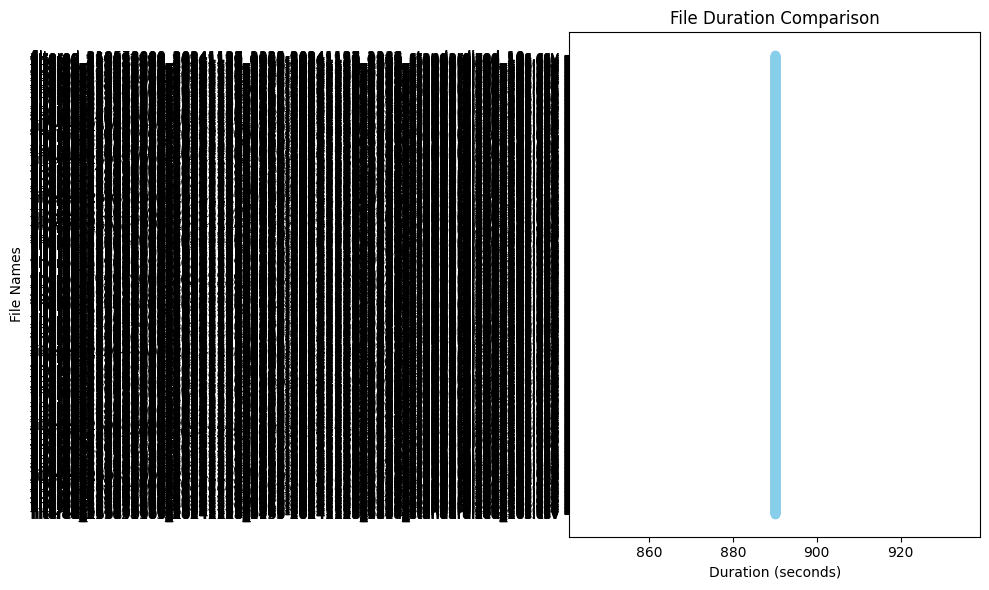

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Specify the folder path where your CSV files are located
folder_path = './time_sets_standardized'

# Lists to store file names and their durations
file_names = []
durations = []

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Convert 'Timestamp' to datetime format
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])

        # Calculate the duration (time between first and last timestamp)
        time_diff = df['Timestamp'].max() - df['Timestamp'].min()

        # Append the file name and duration
        file_names.append(filename)
        durations.append(time_diff.total_seconds())  # Convert to seconds for easy comparison

# Scatter plot with durations on the x-axis
plt.figure(figsize=(10, 6))
plt.scatter(durations, file_names, color='skyblue')
plt.xlabel('Duration (seconds)')
plt.ylabel('File Names')
plt.title('File Duration Comparison')

# Show the plot
plt.tight_layout()
plt.show()
